In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from fuzzywuzzy import process
sns.set(style="whitegrid", color_codes=True)
import plotly.express as px
from scipy import stats
from IPython.display import display
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import chi2_contingency
import matplotlib.patches as patches

## Dataset Description
<p>The dataset, released by Aspiring Minds from the Aspiring Mind Employment Outcome 2015 (AMEO), is focused on engineering students. It encompasses the employment outcomes of these graduates, including dependent variables such as Salary, Job Titles, and Job Locations. The dataset also includes standardized scores from three key areas: cognitive skills, technical skills, and personality skills. Demographic features are incorporated, resulting in around 40 independent variables and 4000 data points. The independent variables comprise both continuous and categorical features, and each candidate is uniquely identified by an ID.</p>

## Objective
<P>objective is to analyze the employment outcomes of engineering graduates. The study aims to explore relationships between various factors (standardized scores, demographic features) and employment-related variables (Salary, Job Titles, and Job Locations). Through univariate and bivariate analyses, the goal is to derive insights into the distribution, patterns, and potential relationships within the dataset.</P>

In [2]:
path = "data.xlsx"
df = pd.read_excel(path)

In [3]:
print(f'Rows :{df.shape[0]}\nColumns:{df.shape[1]}')

df.info()

Rows :3998
Columns:39
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3998 entries, 0 to 3997
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             3998 non-null   object        
 1   ID                     3998 non-null   int64         
 2   Salary                 3998 non-null   int64         
 3   DOJ                    3998 non-null   datetime64[ns]
 4   DOL                    3998 non-null   object        
 5   Designation            3998 non-null   object        
 6   JobCity                3998 non-null   object        
 7   Gender                 3998 non-null   object        
 8   DOB                    3998 non-null   datetime64[ns]
 9   10percentage           3998 non-null   float64       
 10  10board                3998 non-null   object        
 11  12graduation           3998 non-null   int64         
 12  12percentage           3998 non-null   f

## Dataset consists of
- 27 Numerical columns
- 9 catogorical columns
- 2 datetime

In [4]:
print(df.size)

155922


In [5]:
df.nunique()

Unnamed: 0                  1
ID                       3998
Salary                    177
DOJ                        81
DOL                        67
Designation               419
JobCity                   339
Gender                      2
DOB                      1872
10percentage              851
10board                   275
12graduation               16
12percentage              801
12board                   340
CollegeID                1350
CollegeTier                 2
Degree                      4
Specialization             46
collegeGPA               1282
CollegeCityID            1350
CollegeCityTier             2
CollegeState               26
GraduationYear             11
English                   111
Logical                   107
Quant                     138
Domain                    243
ComputerProgramming        79
ElectronicsAndSemicon      29
ComputerScience            20
MechanicalEngg             42
ElectricalEngg             31
TelecomEngg                26
CivilEngg 

### There is an unnamed column, as it has only single value we cannot use this for data analysis. So we need to drop that column.
### Dropping unnecessary columns to keep our dataset clean

In [6]:
df.drop(['Unnamed: 0','ID','CollegeID','CollegeCityID'],axis=1,inplace=True)
df.head()

Salary        DOJ                  DOL               Designation  \
0   420000 2012-06-01              present   senior quality engineer   
1   500000 2013-09-01              present         assistant manager   
2   325000 2014-06-01              present          systems engineer   
3  1100000 2011-07-01              present  senior software engineer   
4   200000 2014-03-01  2015-03-01 00:00:00                       get   

     JobCity Gender        DOB  10percentage                         10board  \
0  Bangalore      f 1990-02-19          84.3  board ofsecondary education,ap   
1     Indore      m 1989-10-04          85.4                            cbse   
2    Chennai      f 1992-08-03          85.0                            cbse   
3    Gurgaon      m 1989-12-05          85.6                            cbse   
4    Manesar      m 1991-02-27          78.0                            cbse   

   12graduation  ...  ComputerScience MechanicalEngg  ElectricalEngg  \
0          2007  ...               -1             -1              -1   
1          2007  ...               -1             -1              -1   
2          2010  ...               -1             -1              -1   
3          2007  ...               -1             -1              -1   
4          2008  ...               -1             -1              -1   

  TelecomEngg CivilEngg  conscientiousness  agreeableness extraversion  \
0          -1        -1             0.9737         0.8128       0.5269   
1          -1        -1            -0.7335         0.3789       1.2396   
2          -1        -1             0.2718         1.7109       0.1637   
3          -1        -1             0.0464         0.3448      -0.3440   
4          -1        -1            -0.8810        -0.2793      -1.0697   

   nueroticism  openess_to_experience  
0      1.35490                -0.4455  
1     -0.10760                 0.8637  
2     -0.86820                 0.6721  
3     -0.40780                -0.9194  
4      0.09163                -0.1295  

[5 rows x 35 columns]

In [7]:
df.duplicated().sum()

0

### The 'DOJ' and 'DOL' columns contain timestamps, which we'll convert into date format using the datetime module. In the 'DOL' column, instances of 'present' will be converted into the current date for our analysis

In [8]:
df["DOJ"]=pd.to_datetime(df["DOJ"]).dt.date
df["DOL"].replace("present",dt.datetime.today(),inplace=True)
df['DOL'] = pd.to_datetime(df['DOL']).dt.date

df['GraduationYear']=pd.to_datetime(df['GraduationYear'])

### Enhancing the descriptive nature of entries in the 'Gender' column.

In [9]:
df['Gender'].replace({'f':'Female','m':'Male'}, inplace = True)

In [10]:
dates = (df['DOL'] < df['DOJ']).sum()
print(f'DOL is earlier than DOJ for {dates} observations out of {df.shape[0]} total observations.')

DOL is earlier than DOJ for 40 observations out of 3998 total observations.


### As there are 40 observation of DOL is greater than DOJ, it suggests that employees might not be satisfied with the offer or could have received better job offers. we can drop those rows

In [11]:
df = df[df['DOL'] > df['DOJ']]
print(df.shape)

(3943, 35)


## Checking no of 0's per column

In [12]:
(df==0).astype(int).sum(axis=0)

Salary                      0
DOJ                         0
DOL                         0
Designation                 0
JobCity                     0
Gender                      0
DOB                         0
10percentage                0
10board                   349
12graduation                0
12percentage                0
12board                   358
CollegeTier                 0
Degree                      0
Specialization              0
collegeGPA                  0
CollegeCityTier          2761
CollegeState                0
GraduationYear              0
English                     0
Logical                     0
Quant                       0
Domain                      0
ComputerProgramming         0
ElectronicsAndSemicon       0
ComputerScience             0
MechanicalEngg              0
ElectricalEngg              0
TelecomEngg                 0
CivilEngg                   0
conscientiousness           0
agreeableness               0
extraversion                0
nueroticis

## Checking no of -1's and Nan per column

In [13]:
df.isin([-1, 'NaN']).sum()

Salary                      0
DOJ                         0
DOL                         0
Designation                 0
JobCity                   448
Gender                      0
DOB                         0
10percentage                0
10board                     0
12graduation                0
12percentage                0
12board                     0
CollegeTier                 0
Degree                      0
Specialization              0
collegeGPA                  0
CollegeCityTier             0
CollegeState                0
GraduationYear              0
English                     0
Logical                     0
Quant                       0
Domain                    242
ComputerProgramming       861
ElectronicsAndSemicon    2815
ComputerScience          3060
MechanicalEngg           3708
ElectricalEngg           3789
TelecomEngg              3571
CivilEngg                3901
conscientiousness           0
agreeableness               0
extraversion                0
nueroticis

In [14]:
df.loc[df['collegeGPA'] <= 10, 'collegeGPA'] *= 10

### Few of the collegeGPA is in CGPA so converting to percentage

In [15]:
df["JobCity"].mode().to_list()[0]

'Bangalore'

In [16]:
df['GraduationYear'].fillna(df['GraduationYear'].mode()[0], inplace = True)
df['JobCity'].fillna(df['JobCity'].mode()[0], inplace = True)

## Replacing Nan value with mode value of the column

In [17]:
df[df["10board"]==0][["Salary","Designation","JobCity","Gender","10percentage","10board","12percentage","12board","Degree","Specialization","CollegeState","Specialization"]].mode()

Salary        Designation    JobCity Gender  10percentage 10board  \
0  400000  software engineer  Bangalore   Male          75.0       0   

   12percentage 12board       Degree        Specialization CollegeState  \
0          65.0       0  B.Tech/B.E.  computer engineering   Tamil Nadu   

         Specialization  
0  computer engineering

In [18]:
board10_mode_value=[]
board10_mode_value.append(df[df["Designation"]=="software engineer"]["10board"].mode().to_list()[0])
board10_mode_value.append(df[df["Gender"]=="Male"]["10board"].mode().to_list()[0])
board10_mode_value.append(df[df["10percentage"]==75]["10board"].mode().to_list()[0])
board10_mode_value.append(df[df["JobCity"]=="Bengaluru"]["10board"].mode().to_list()[0])
board10_mode_value.append(df[df["12percentage"]==65]["10board"].mode().to_list()[0])
board10_mode_value.append(df[df["collegeGPA"]==65]["10board"].mode().to_list()[0])
board10_mode_value.append(df[df["Salary"]==400000]["10board"].mode().to_list()[0])
board10_mode_value.append(df[df["Degree"].str.startswith("B.Tech/")]["10board"].mode().to_list()[0])
board10_mode_value.append(df[df["Specialization"].str.startswith("computer eng")]["10board"].mode().to_list()[0])
board10_mode_value.append(df[df["CollegeState"].str.startswith("Tamil Nadu")]["10board"].mode().to_list()[0])
board10_mode_value

['cbse',
 'cbse',
 'cbse',
 'state board',
 'cbse',
 'cbse',
 'cbse',
 'cbse',
 'cbse',
 'state board']

### Extracting the mode of the '10board' column under various conditions (e.g., for specific designations, genders, percentages, cities, etc.)

In [19]:
board10_mode_series = pd.Series(board10_mode_value)
mode_value = board10_mode_series.mode()

In [20]:
mode_value

0    cbse
dtype: object

In [21]:
df['10board'].replace(0, mode_value.iloc[0], inplace=True)

In [22]:
df[df["12board"]==0][["Salary","Designation","JobCity","Gender","10percentage","12board","12percentage","12board","Degree","collegeGPA","Specialization","CollegeState","Specialization"]].mode()

Salary      Designation    JobCity Gender  10percentage 12board  \
0  400000.0  system engineer  Bangalore   Male          75.0       0   
1       NaN              NaN        NaN    NaN           NaN     NaN   

   12percentage 12board       Degree  collegeGPA        Specialization  \
0          65.0       0  B.Tech/B.E.        65.0  computer engineering   
1           NaN     NaN          NaN        72.0                   NaN   

  CollegeState        Specialization  
0   Tamil Nadu  computer engineering  
1          NaN                   NaN

In [23]:
board12_mode_value=[]
board12_mode_value.append(df[df["Designation"]=="system engineer"]["12board"].mode().to_list()[0])
board12_mode_value.append(df[df["Gender"]=="Male"]["12board"].mode().to_list()[0])
board12_mode_value.append(df[df["10percentage"]==75]["12board"].mode().to_list()[0])
board12_mode_value.append(df[df["JobCity"]=="Bengaluru"]["12board"].mode().to_list()[0])
board12_mode_value.append(df[df["12percentage"]==65]["12board"].mode().to_list()[0])
board12_mode_value.append(df[df["collegeGPA"]==65]["12board"].mode().to_list()[0])
board12_mode_value.append(df[df["Salary"]==400000]["12board"].mode().to_list()[0])
board12_mode_value.append(df[df["Degree"].str.startswith("B.Tech/")]["12board"].mode().to_list()[0])
board12_mode_value.append(df[df["Specialization"].str.startswith("computer eng")]["12board"].mode().to_list()[0])
board12_mode_value.append(df[df["CollegeState"].str.startswith("Tamil Nadu")]["12board"].mode().to_list()[0])
board12_mode_value

['cbse',
 'cbse',
 'cbse',
 'state board',
 'cbse',
 'cbse',
 'cbse',
 'cbse',
 'cbse',
 'state board']

In [24]:
df['12board'].mode()[0]

'cbse'

In [25]:
df['12board'].replace(0, df['12board'].mode()[0], inplace=True)

### Replacing 0 with mode value in 12board Column

In [26]:
df['CollegeCityTier'].unique()

array([0, 1], dtype=int64)

### Converting CollegeCityTier column to object as it is categorical in nature

In [27]:
df['CollegeCityTier'] = df['CollegeCityTier'].astype('object')

### We need to handle the 'get' values in the 'Designation' column which is not a desired value by replacing them with the mode of the column.

In [28]:
df[df["Designation"]=="get"][['DOJ','DOL',"JobCity","Gender","10percentage","10board","12percentage","12board","Degree","Specialization","CollegeState","GraduationYear"]].mode()

DOJ         DOL    JobCity Gender  10percentage 10board  \
0   2010-03-01  2024-02-23  Hyderabad   Male          80.0    cbse   
1   2010-07-01         NaN        NaN    NaN           NaN     NaN   
2   2010-10-01         NaN        NaN    NaN           NaN     NaN   
3   2011-07-01         NaN        NaN    NaN           NaN     NaN   
4   2012-10-01         NaN        NaN    NaN           NaN     NaN   
5   2013-01-01         NaN        NaN    NaN           NaN     NaN   
6   2013-08-01         NaN        NaN    NaN           NaN     NaN   
7   2014-03-01         NaN        NaN    NaN           NaN     NaN   
8   2014-04-01         NaN        NaN    NaN           NaN     NaN   
9   2014-05-01         NaN        NaN    NaN           NaN     NaN   
10  2014-06-01         NaN        NaN    NaN           NaN     NaN   
11  2014-07-01         NaN        NaN    NaN           NaN     NaN   
12  2014-10-01         NaN        NaN    NaN           NaN     NaN   
13  2015-01-01         NaN        NaN    NaN           NaN     NaN   

    12percentage 12board       Degree          Specialization   CollegeState  \
0          64.20    cbse  B.Tech/B.E.  mechanical engineering  Uttar Pradesh   
1          67.00     NaN          NaN                     NaN            NaN   
2          72.00     NaN          NaN                     NaN            NaN   
3          73.40     NaN          NaN                     NaN            NaN   
4          73.80     NaN          NaN                     NaN            NaN   
5          74.40     NaN          NaN                     NaN            NaN   
6          74.53     NaN          NaN                     NaN            NaN   
7          76.00     NaN          NaN                     NaN            NaN   
8          76.80     NaN          NaN                     NaN            NaN   
9          79.90     NaN          NaN                     NaN            NaN   
10         82.70     NaN          NaN                     NaN            NaN   
11         85.80     NaN          NaN                     NaN            NaN   
12         90.00     NaN          NaN                     NaN            NaN   
13         90.60     NaN          NaN                     NaN            NaN   

                  GraduationYear  
0  1970-01-01 00:00:00.000002014  
1                            NaT  
2                            NaT  
3                            NaT  
4                            NaT  
5                            NaT  
6                            NaT  
7                            NaT  
8                            NaT  
9                            NaT  
10                           NaT  
11                           NaT  
12                           NaT  
13                           NaT

In [29]:
df['DOL'] = pd.to_datetime(df['DOL'])
df['DOJ'] = pd.to_datetime(df['DOJ'])

getValue=[]
getValue.append(df[df["DOL"].dt.year == 2024]["Designation"].mode().to_list()[0])
getValue.append(df[df["JobCity"]=="Hyderabad"]["Designation"].mode().to_list()[0])
getValue.append(df[df["Gender"]=="Male"]["Designation"].mode().to_list()[0])
getValue.append(df[df["10percentage"]==80]["Designation"].mode().to_list()[0])
getValue.append(df[df["10board"]=="cbse"]["Designation"].mode().to_list()[0])
getValue.append(df[df["12percentage"]==64.2]["Designation"].mode().to_list()[0])
getValue.append(df[df["12board"]=="cbse"]["Designation"].mode().to_list()[0])
getValue.append(df[df["Degree"].str.startswith("B.Tech/")]["Designation"].mode().to_list()[0])
getValue.append(df[df["Specialization"].str.startswith("mechanical")]["Designation"].mode().to_list()[0])
getValue.append(df[df["CollegeState"].str.startswith("Uttar Pradesh")]["Designation"].mode().to_list()[0])
getValue.append(df[df["GraduationYear"].dt.year==2014]["Designation"].mode())
getValue

['software engineer',
 'software engineer',
 'software engineer',
 'software engineer',
 'software engineer',
 'get',
 'software engineer',
 'software engineer',
 'production engineer',
 'software engineer',
 Series([], Name: Designation, dtype: object)]

In [30]:
getValue_mode_series = pd.Series(getValue)
get_mode_value = getValue_mode_series.mode()
df['Designation'].replace('get', get_mode_value.iloc[0], inplace=True)

### Replacing Nan value in Jobcity column with mode and cleaning the column which have similar meaning

In [31]:
df['JobCity'] = df['JobCity'].str.strip()

In [32]:
df["JobCity"].replace(np.nan, df["JobCity"].mode().to_list()[0],inplace=True)

In [33]:
df["JobCity"].value_counts(dropna=False)

Bangalore           1085
Noida                363
Hyderabad            339
Pune                 291
Chennai              277
                    ... 
BAngalore              1
Asansol                1
Tirunelvelli           1
Ernakulam              1
Asifabadbanglore       1
Name: JobCity, Length: 299, dtype: int64

In [34]:
df['JobCity'] = df['JobCity'].str.capitalize()

In [35]:
from fuzzywuzzy import process

def correct_spelling_errors(target_word="", choices=[], threshold=80):
    match, score = process.extractOne(target_word, choices)
    if score >= threshold:
        return match
    else:
        return target_word
    
choices=['Bengaluru','Hyderabad','Jaipur','Gandhi Nagar','Saudi Arabia','Bhubaneswar','Mysore','Australia','New Delhi','Nagpur','Pune','Trivandrum','Mumbai','Noida','Visakhapatnam','Odisha','Chennai','Lucknow','Kolkata','Kota','London','Mohali','Gurgaon','Bihar','Ariyalur','Rae Bareli','Tirupathi','Vizag','Ghaziabad','Uttar Pradesh','Faridabad','Ahmedabad','Ranchi','Haryana','Thane','Bhopal','Meerut','Cheyyar','Rajasthan','Dehradun','Kanpur','Kolhapur','Bhubaneswar']

In [36]:
df['JobCity'] = df['JobCity'].apply(lambda jobcity: correct_spelling_errors(str(jobcity), choices))

In [37]:
df["JobCity"].unique()

array(['Bangalore', 'Indore', 'Chennai', 'Gurgaon', 'Manesar',
       'Hyderabad', 'Banglore', 'Noida', 'Kolkata', 'Pune', 'Mohali',
       'Jhansi', 'New Delhi', 'Bhubaneswar', 'Mumbai', 'Mangalore',
       'Rewari', 'Ghaziabad', 'Bhiwadi', 'Mysore', 'Rajkot', 'Jaipur',
       'Thane', 'Maharajganj', 'Thiruvananthapuram', 'Punchkula',
       'Coimbatore', 'Dhanbad', 'Lucknow', 'Trivandrum', 'Gandhi Nagar',
       'Una', 'Daman and diu', 'Visakhapatnam', 'Nagpur', 'Bhagalpur',
       'Ahmedabad', 'Kochi/cochin', 'Bankura', 'Bengaluru', 'Kanpur',
       'Vijayawada', 'Kochi', 'Beawar', 'Alwar', 'Siliguri', 'Bhopal',
       'Faridabad', 'Jodhpur', 'Udaipur', 'Muzaffarpur', 'Bulandshahar',
       'Haridwar', 'Raigarh', 'Jabalpur', 'Unnao', 'Aurangabad',
       'Belgaum', 'Dehradun', 'Rudrapur', 'Jamshedpur', 'Vizag',
       'Dharamshala', 'Banagalore', 'Hissar', 'Ranchi', 'Madurai',
       'Chandigarh', 'Australia', 'Cheyyar', 'Sonepat', 'Pantnagar',
       'Jagdalpur', 'Angul', 'Baroda',

In [38]:
df["JobCity"].replace("Bangalore","Bengaluru",inplace=True)
df["JobCity"].replace("Banaglore","Bengaluru",inplace=True)
df["JobCity"].replace("Banagalore","Bengaluru",inplace=True)
df["JobCity"].replace("Bangalore","Bengaluru",inplace=True)
df["JobCity"].replace("Banglore","Bengaluru",inplace=True)
df["JobCity"].replace("Bangalore ","Bengaluru",inplace=True)

df["JobCity"].replace("Secunderabad","Hyderabad",inplace=True)

df["JobCity"].replace("Chennai, Bangalore","Chennai",inplace=True)

df["JobCity"].replace("Jaipur ","Jaipur",inplace=True)
df["JobCity"].replace("Gandhinagar","Gandhi Nagar",inplace=True)

df["JobCity"].replace("Jaipur ","Jaipur",inplace=True)
df["JobCity"].replace("Gandhinagar","Gandhi Nagar",inplace=True)
df["JobCity"].replace("Hyderabad ","Hyderabad",inplace=True)
df["JobCity"].replace("Hyderabad(Bhadurpally)","Hyderabad",inplace=True)
df["JobCity"].replace("Bhubaneswar ","Bhubaneswar",inplace=True)
df["JobCity"].replace("Delhi/ncr","New Delhi",inplace=True)
df["JobCity"].replace("Delhi/Ncr","New Delhi",inplace=True)

df["JobCity"].replace("Ncr","New Delhi",inplace=True)
df["JobCity"].replace("Trivandrum ","Trivandrum",inplace=True)
df["JobCity"].replace("Thiruvananthapuram","Trivandrum",inplace=True)
df["JobCity"].replace("Asifabadbanglore","Bengaluru",inplace=True)
df["JobCity"].replace("Kochi/Cochin, Chennai and Coimbatore","Chennai",inplace=True)
df["JobCity"].replace("Bangalore","Bengaluru",inplace=True)
df["JobCity"].replace("Coimbatore","Chennai",inplace=True)
df["JobCity"].replace("Kochi/Cochin","Chennai",inplace=True)
df["JobCity"].replace("Kochi/cochin","Chennai",inplace=True)
df["JobCity"].replace("Kochi","Chennai",inplace=True)
df["JobCity"].replace("Latur (maharashtra )","Maharashtra",inplace=True)
df["JobCity"].replace("Orissa","Odisha",inplace=True)

df["JobCity"].replace("Al jubail,saudi arabia","Saudi Arabia",inplace=True)
df["JobCity"].replace("Jeddah saudi arabia","Saudi Arabia",inplace=True)

### Checking the distribution of -1 value in the columns and droping drop those columns where the percentage of -1 values is greater than 80%.

In [39]:
result = (df == -1).mean() * 100
result = result[result > 0]
result

Domain                    6.137459
ComputerProgramming      21.836165
ElectronicsAndSemicon    71.392341
ComputerScience          77.605884
MechanicalEngg           94.040071
ElectricalEngg           96.094344
TelecomEngg              90.565559
CivilEngg                98.934821
dtype: float64

In [40]:
df = df.drop(columns = ['MechanicalEngg', 'ElectricalEngg', 'TelecomEngg', 'CivilEngg'])

In [41]:
df.shape

(3943, 31)

In [42]:
df['Domain'].replace(-1,df['Domain'].median(),inplace=True)
df['ComputerProgramming'].replace(-1,df['ComputerProgramming'].median(),inplace=True)
df['ElectronicsAndSemicon'].replace(-1,0,inplace=True)
df['ComputerScience'].replace(-1,0,inplace=True)

In [43]:
specialization = {'electronics and communication engineering' : 'ECE',
 'computer science & engineering' : 'CSE',
 'information technology' : 'CSE' ,
 'computer engineering' : 'CSE',
 'computer application' : 'CSE',
 'mechanical engineering' : 'ME',
 'electronics and electrical engineering' : 'ECE',
 'electronics & telecommunications' : 'ECE',
 'electrical engineering' : 'EL',
 'electronics & instrumentation eng' : 'ECE',
 'civil engineering' : 'CE',
 'electronics and instrumentation engineering' : 'ECE',
 'information science engineering' : 'CSE',
 'instrumentation and control engineering' : 'ECE',
 'electronics engineering' : 'ECE',
 'biotechnology' : 'other',
 'other' : 'other',
 'industrial & production engineering' : 'other',
 'chemical engineering' : 'other',
 'applied electronics and instrumentation' : 'ECE',
 'computer science and technology' : 'CSE',
 'telecommunication engineering' : 'ECE',
 'mechanical and automation' : 'ME',
 'automobile/automotive engineering' : 'ME',
 'instrumentation engineering' : 'ECE',
 'mechatronics' : 'ME',
 'electronics and computer engineering' : 'CSE',
 'aeronautical engineering' : 'ME',
 'computer science' : 'CSE',
 'metallurgical engineering' : 'other',
 'biomedical engineering' : 'other',
 'industrial engineering' : 'other',
 'information & communication technology' : 'ECE',
 'electrical and power engineering' : 'EL',
 'industrial & management engineering' : 'other',
 'computer networking' : 'CSE',
 'embedded systems technology' : 'ECE',
 'power systems and automation' : 'EL',
 'computer and communication engineering' : 'CSE',
 'information science' : 'CSE',
 'internal combustion engine' : 'ME',
 'ceramic engineering' : 'other',
 'mechanical & production engineering' : 'ME',
 'control and instrumentation engineering' : 'ECE',
 'polymer technology' : 'other',
 'electronics' : 'ECE'}

df['Specialization'] = df['Specialization'].map(specialization)
df['Specialization'].unique()

array(['CSE', 'ECE', 'ME', 'EL', 'CE', 'other'], dtype=object)

### Specializations has many values.We need to impute it with simplified set of categories.

# Univariate Analysis

In [44]:
numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns
def describe(numeric_columns):
    result_df = pd.DataFrame()
    for column in numeric_columns:
        statistics = df[column].agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurt']).to_frame(name=column)
        result_df = pd.concat([result_df, statistics], axis=1)

    return result_df

result_dataframe = describe(numeric_columns)

result_dataframe.T

min           max           mean  \
Salary                 35000.00000  4.000000e+06  308256.150139   
10percentage              43.00000  9.776000e+01      77.946551   
12graduation            1995.00000  2.013000e+03    2008.073802   
12percentage              40.00000  9.870000e+01      74.459954   
CollegeTier                1.00000  2.000000e+00       1.925184   
collegeGPA                49.07000  9.993000e+01      71.699419   
English                  180.00000  8.750000e+02     501.786203   
Logical                  195.00000  7.950000e+02     501.607152   
Quant                    120.00000  9.000000e+02     513.307380   
Domain                     0.00275  9.999104e-01       0.610972   
ComputerProgramming      105.00000  8.400000e+02     443.714938   
ElectronicsAndSemicon      0.00000  6.120000e+02      96.093837   
ComputerScience            0.00000  7.150000e+02      90.862034   
conscientiousness         -4.12670  1.995300e+00      -0.039480   
agreeableness             -5.78160  1.904800e+00       0.146107   
extraversion              -4.60090  2.535400e+00      -0.001356   
nueroticism               -2.64300  3.352500e+00      -0.170278   
openess_to_experience     -7.37570  1.822400e+00      -0.139331   

                              median            std      skew       kurt  
Salary                 300000.000000  211763.101565  6.532103  83.081149  
10percentage               79.200000       9.839517 -0.597075  -0.092723  
12graduation             2008.000000       1.656707 -0.957824   1.934794  
12percentage               74.400000      11.001894 -0.036150  -0.624431  
CollegeTier                 2.000000       0.263128 -3.233407   8.459212  
collegeGPA                 71.770000       7.417355  0.171414   0.077574  
English                   500.000000     104.804712  0.195006  -0.249051  
Logical                   505.000000      86.654853 -0.217682  -0.225539  
Quant                     515.000000     122.213111 -0.018387  -0.093421  
Domain                      0.622643       0.264790 -0.409836  -0.820494  
ComputerProgramming       415.000000      87.400354  0.228343   1.136621  
ElectronicsAndSemicon       0.000000     157.948591  1.198618  -0.201749  
ComputerScience             0.000000     174.450593  1.543146   0.740457  
conscientiousness           0.046400       1.027460 -0.523367   0.114958  
agreeableness               0.212400       0.941440 -1.210802   3.443169  
extraversion                0.091400       0.952427 -0.522134   0.644928  
nueroticism                -0.234400       1.007118  0.169085  -0.197075  
openess_to_experience      -0.094300       1.006140 -1.501678   5.813180

In [45]:
df.describe().T

count           mean            std          min  \
Salary                 3943.0  308256.150139  211763.101565  35000.00000   
10percentage           3943.0      77.946551       9.839517     43.00000   
12graduation           3943.0    2008.073802       1.656707   1995.00000   
12percentage           3943.0      74.459954      11.001894     40.00000   
CollegeTier            3943.0       1.925184       0.263128      1.00000   
collegeGPA             3943.0      71.699419       7.417355     49.07000   
English                3943.0     501.786203     104.804712    180.00000   
Logical                3943.0     501.607152      86.654853    195.00000   
Quant                  3943.0     513.307380     122.213111    120.00000   
Domain                 3943.0       0.610972       0.264790      0.00275   
ComputerProgramming    3943.0     443.714938      87.400354    105.00000   
ElectronicsAndSemicon  3943.0      96.093837     157.948591      0.00000   
ComputerScience        3943.0      90.862034     174.450593      0.00000   
conscientiousness      3943.0      -0.039480       1.027460     -4.12670   
agreeableness          3943.0       0.146107       0.941440     -5.78160   
extraversion           3943.0      -0.001356       0.952427     -4.60090   
nueroticism            3943.0      -0.170278       1.007118     -2.64300   
openess_to_experience  3943.0      -0.139331       1.006140     -7.37570   

                                 25%            50%            75%  \
Salary                 180000.000000  300000.000000  372500.000000   
10percentage               71.800000      79.200000      85.725000   
12graduation             2007.000000    2008.000000    2009.000000   
12percentage               66.000000      74.400000      82.580000   
CollegeTier                 2.000000       2.000000       2.000000   
collegeGPA                 66.500000      71.770000      76.400000   
English                   425.000000     500.000000     570.000000   
Logical                   445.000000     505.000000     565.000000   
Quant                     430.000000     515.000000     595.000000   
Domain                      0.413838       0.622643       0.842248   
ComputerProgramming       405.000000     415.000000     495.000000   
ElectronicsAndSemicon       0.000000       0.000000     233.000000   
ComputerScience             0.000000       0.000000       0.000000   
conscientiousness          -0.726400       0.046400       0.702700   
agreeableness              -0.287100       0.212400       0.812800   
extraversion               -0.604800       0.091400       0.672000   
nueroticism                -0.868200      -0.234400       0.526200   
openess_to_experience      -0.669200      -0.094300       0.502400   

                                max  
Salary                 4.000000e+06  
10percentage           9.776000e+01  
12graduation           2.013000e+03  
12percentage           9.870000e+01  
CollegeTier            2.000000e+00  
collegeGPA             9.993000e+01  
English                8.750000e+02  
Logical                7.950000e+02  
Quant                  9.000000e+02  
Domain                 9.999104e-01  
ComputerProgramming    8.400000e+02  
ElectronicsAndSemicon  6.120000e+02  
ComputerScience        7.150000e+02  
conscientiousness      1.995300e+00  
agreeableness          1.904800e+00  
extraversion           2.535400e+00  
nueroticism            3.352500e+00  
openess_to_experience  1.822400e+00

In [46]:
df.describe(include = 'object').T

count unique                top  freq
Designation      3943    415  software engineer   549
JobCity          3943    184          Bengaluru  1131
Gender           3943      2               Male  2998
10board          3943    274               cbse  1725
12board          3943    339               cbse  1737
Degree           3943      4        B.Tech/B.E.  3648
Specialization   3943      6                CSE  2259
CollegeCityTier  3943      2                  0  2761
CollegeState     3943     26      Uttar Pradesh   902

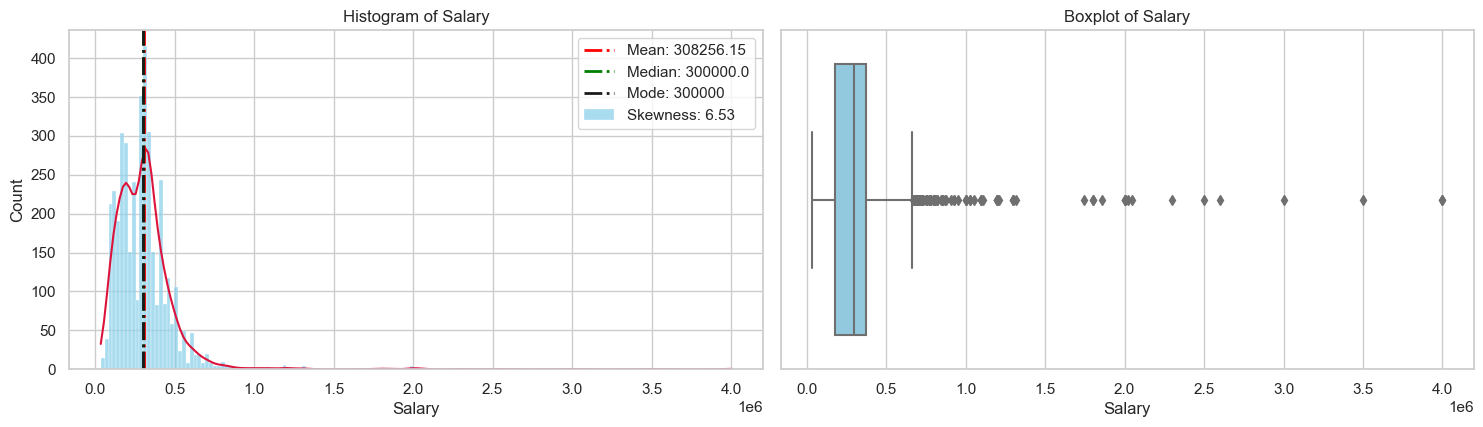

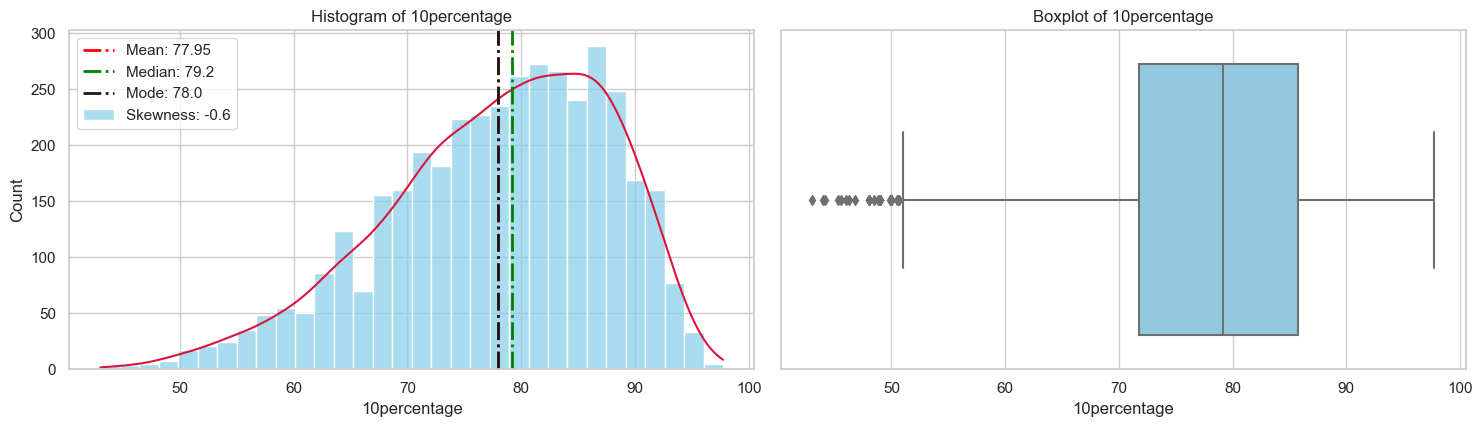

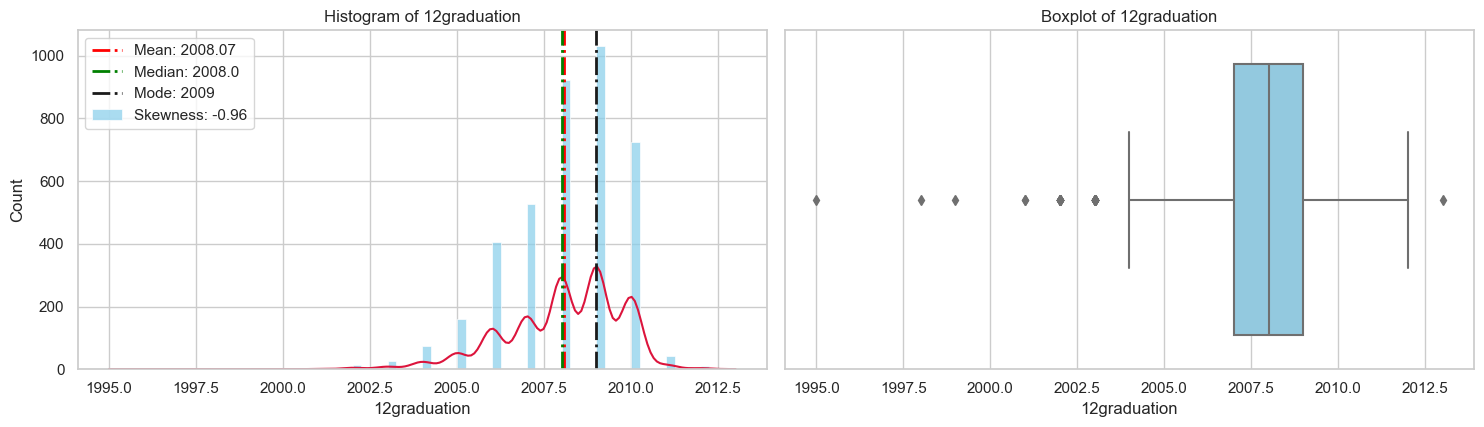

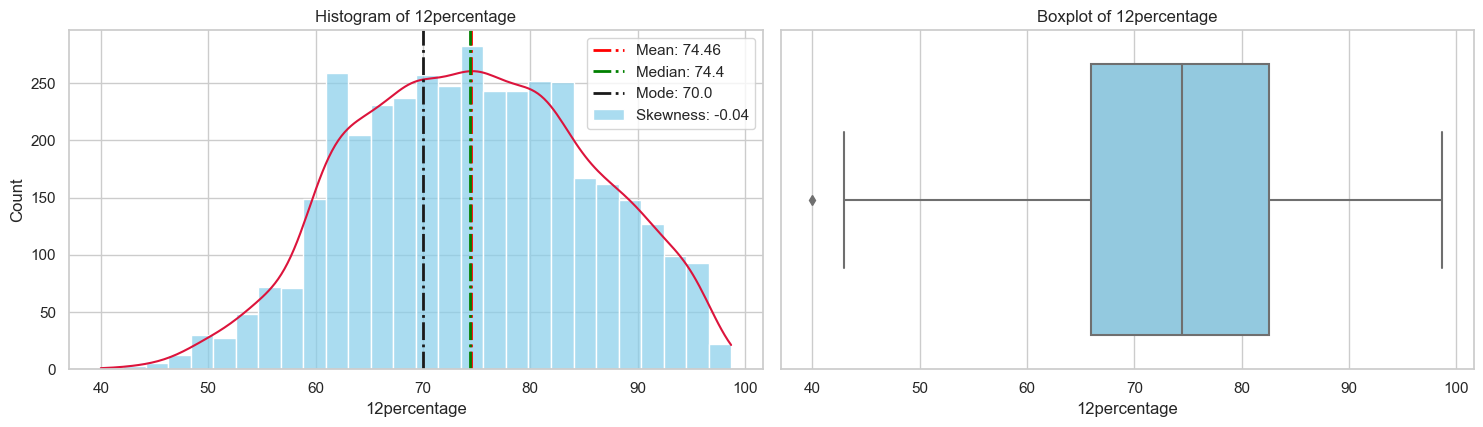

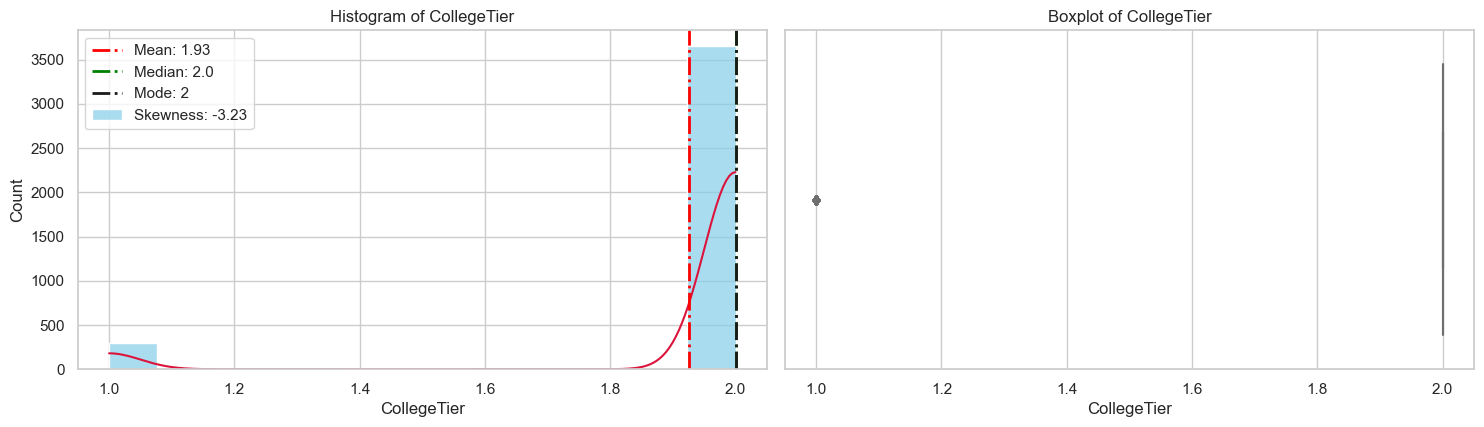

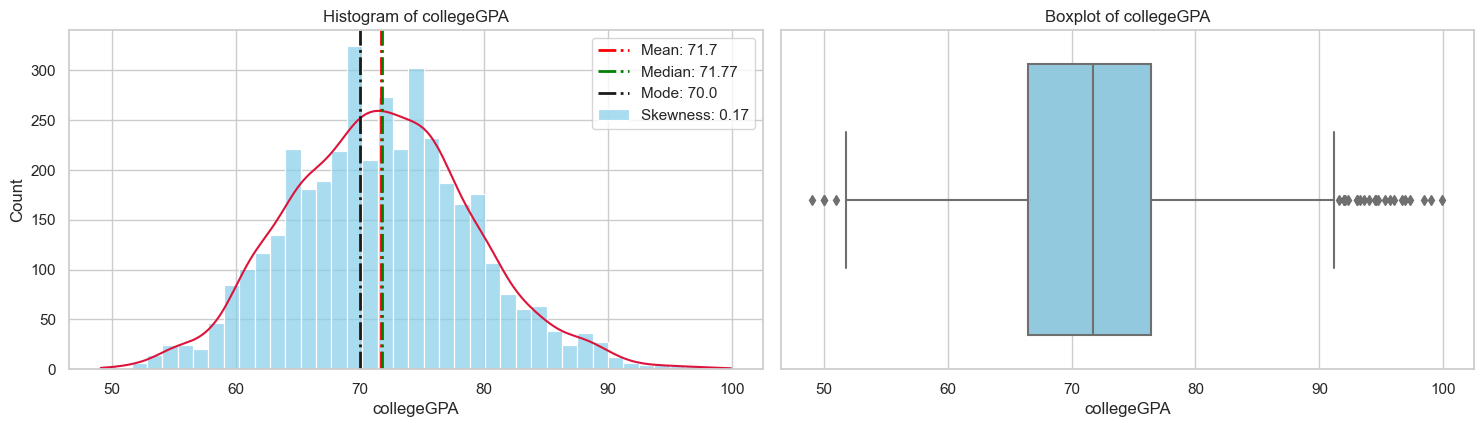

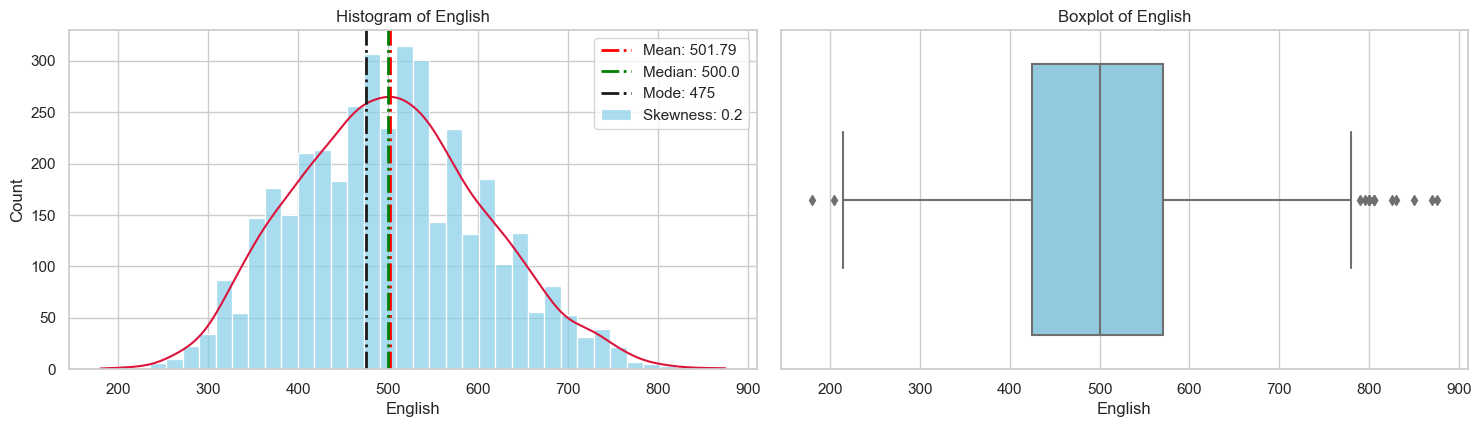

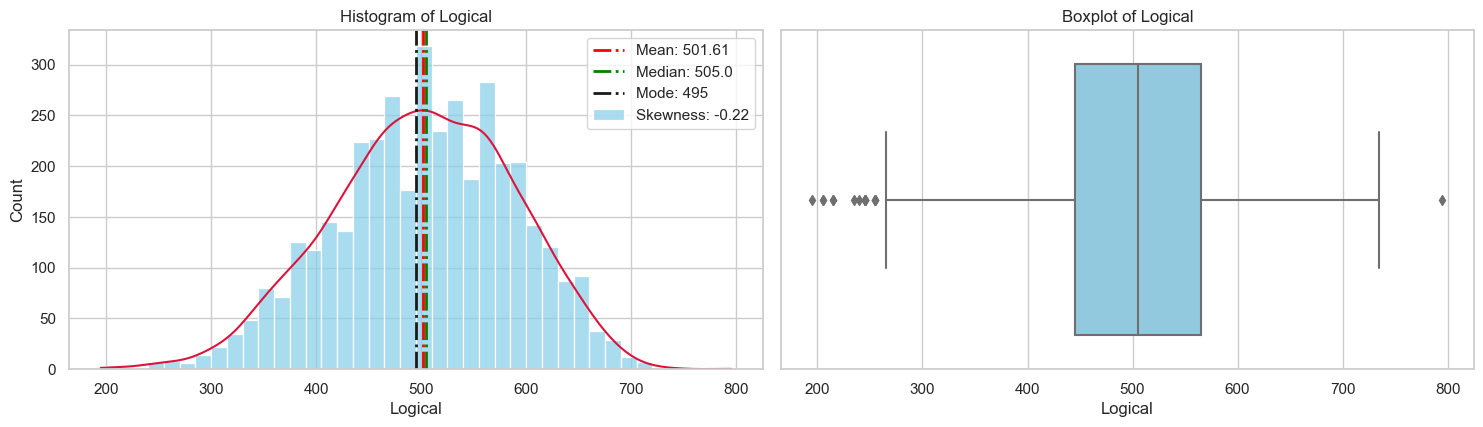

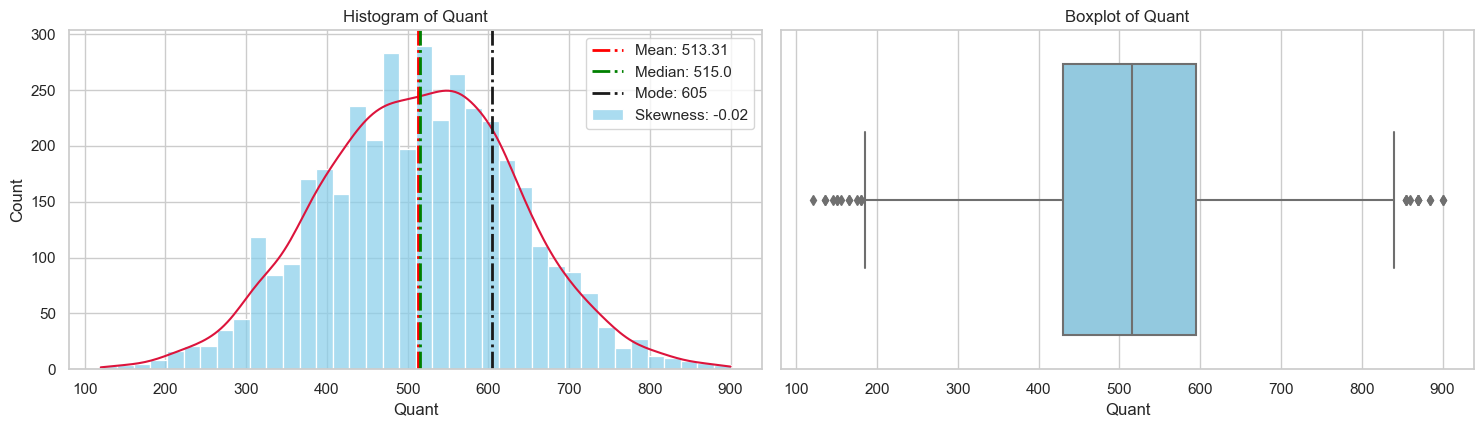

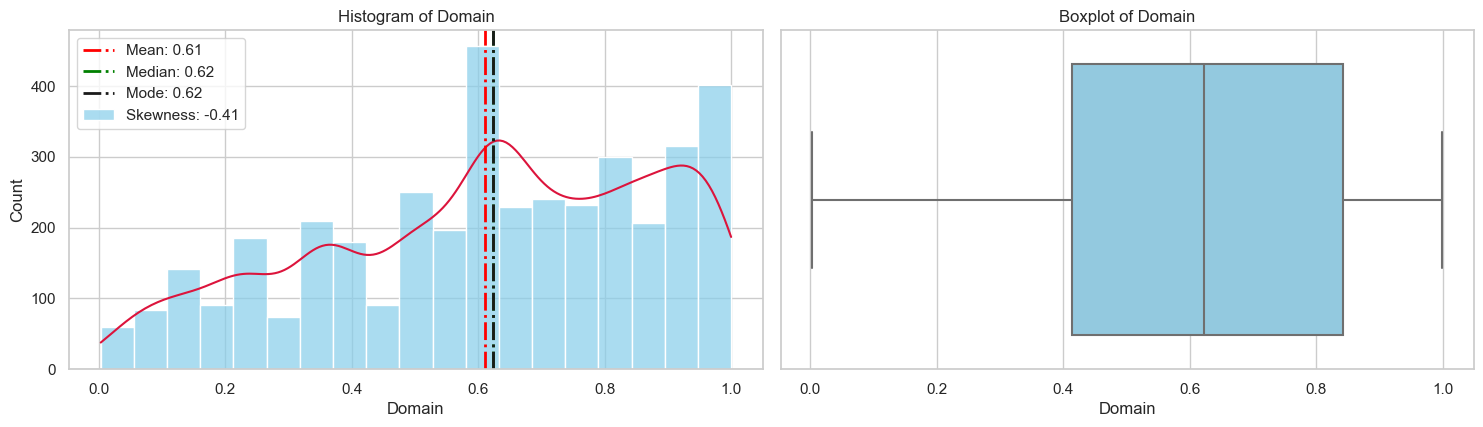

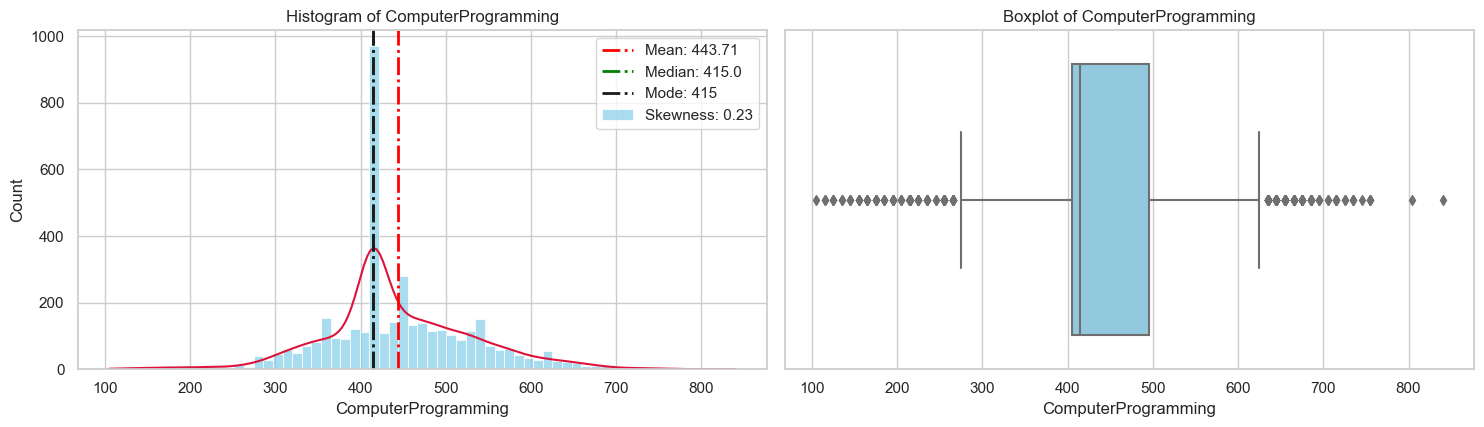

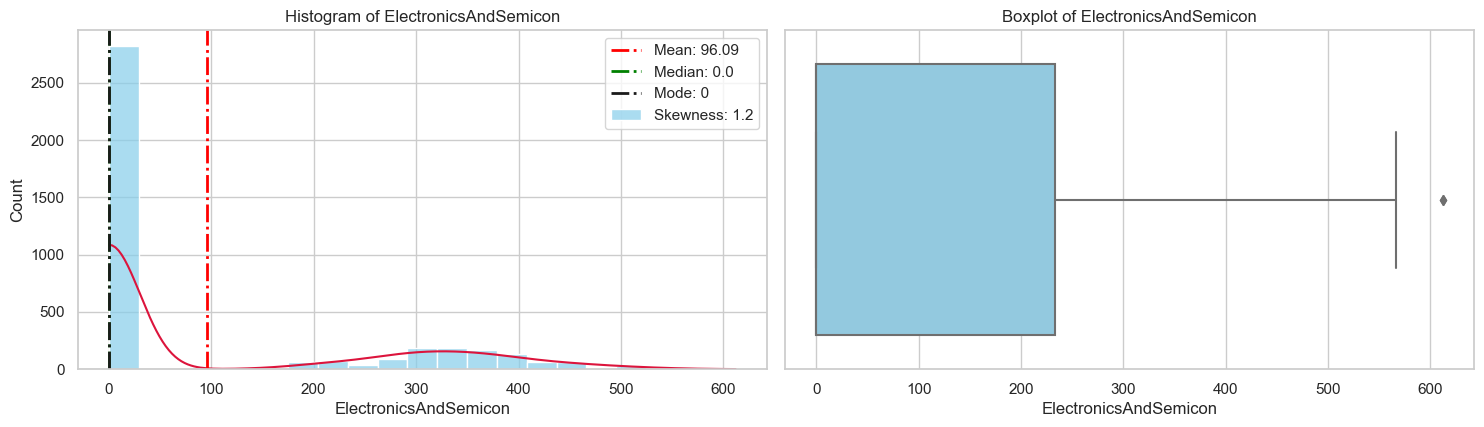

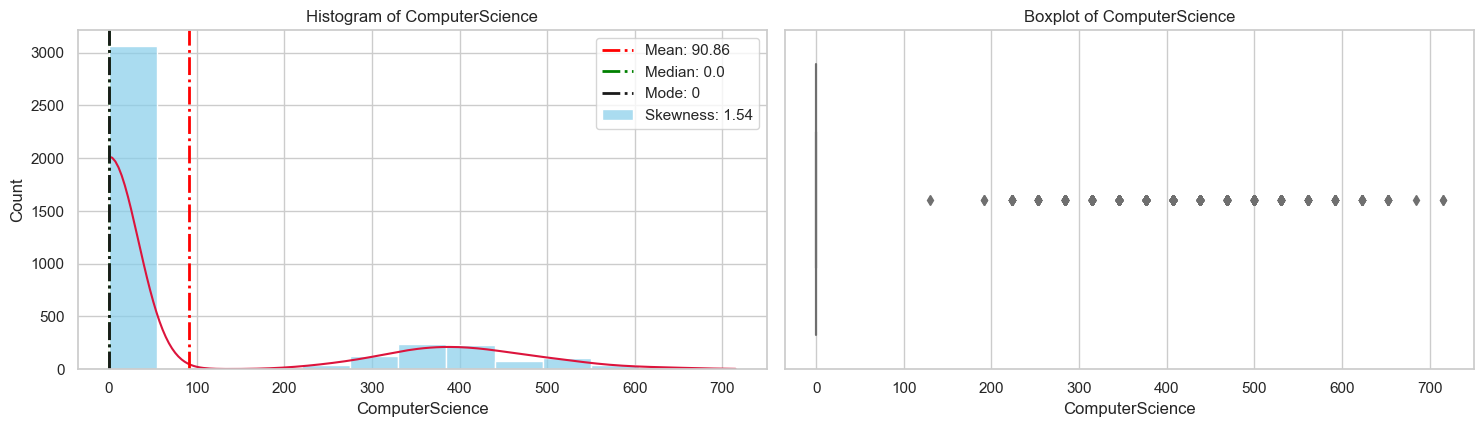

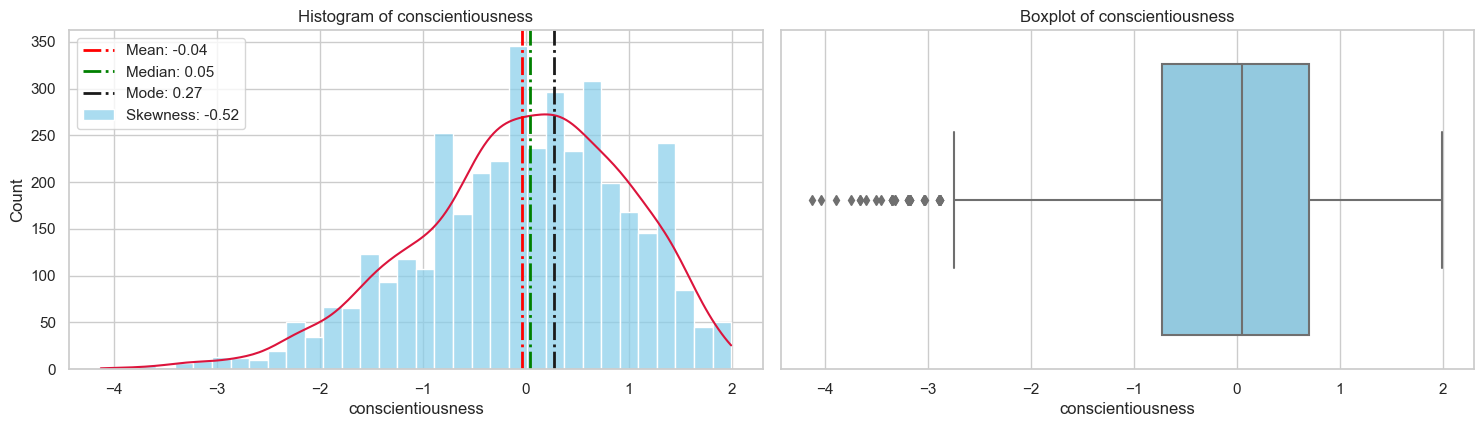

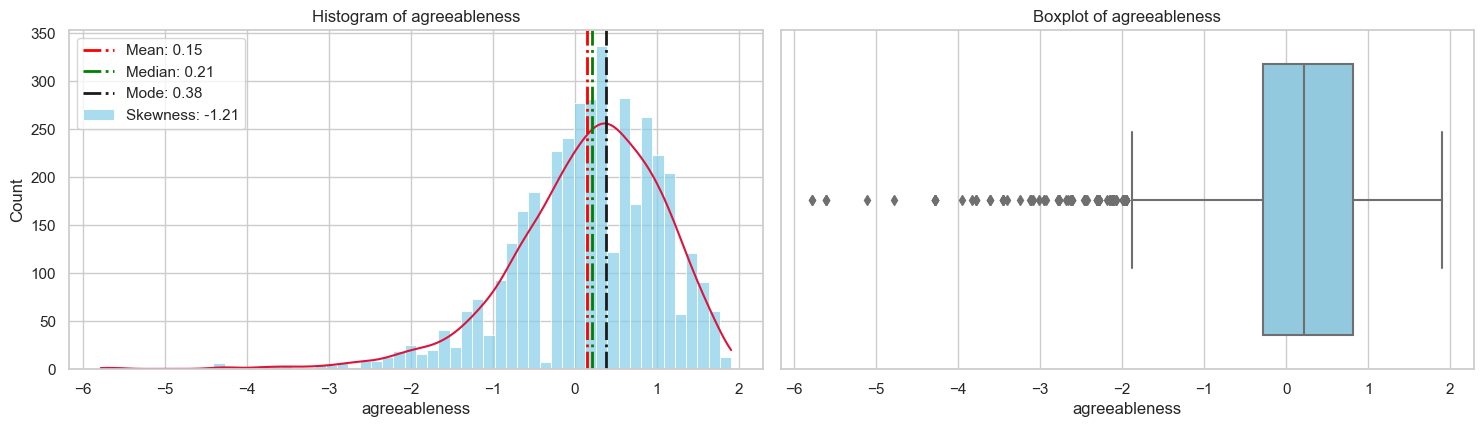

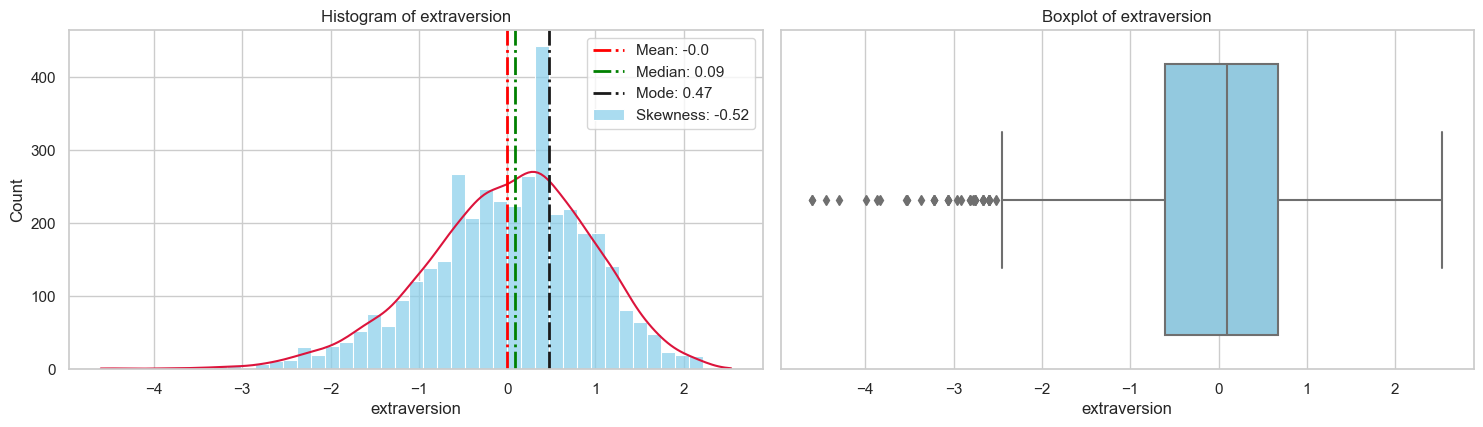

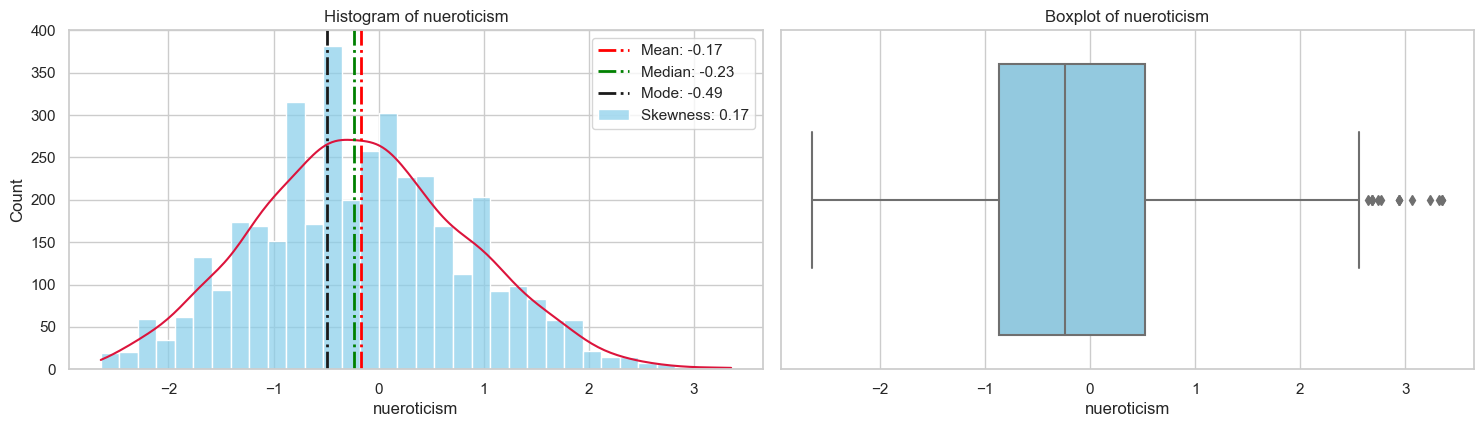

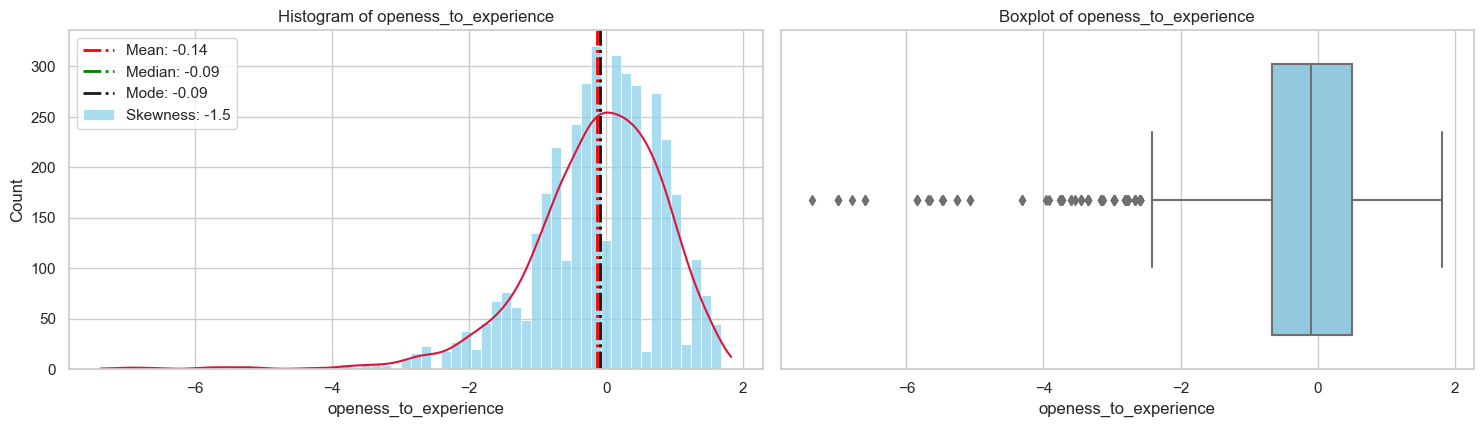

In [47]:
## numeric_columns = ['Salary', '10percentage', '12percentage', 'collegeGPA']
def univariate_analysis_numeric(column):
    plt.figure(figsize=(15, 8))

    # Histogram with KDE
    plt.subplot(2, 2, 1)
    ax = sns.histplot(df[column], kde=True, label=f"Skewness: {round(df[column].skew(),2)}", alpha=0.7, color='skyblue')
    ax.lines[0].set_color('crimson')

    
    plt.axvline(df[column].mean(), label=f"Mean: {round(df[column].mean(),2)}", linestyle='-.', color='red', linewidth=2)
    plt.axvline(df[column].median(), label=f"Median: {round(df[column].median(),2)}", linestyle='-.', color='green', linewidth=2)
    plt.axvline(df[column].mode()[0], label=f"Mode: {round(df[column].mode()[0],2)}", linestyle='-.', color='k', linewidth=2)

    plt.title(f'Histogram of {column}')
    plt.legend()

    # Boxplot
    plt.subplot(2, 2, 2)
    sns.boxplot(x=df[column], color='skyblue')
    plt.title(f'Boxplot of {column}')
    
    plt.tight_layout()
    plt.show()


for column in numeric_columns:
    univariate_analysis_numeric(column)


- Salary: The Histogram exhibits a right-skewed distribution with a long tail on the right side, resembling a log-normal distribution. The box plot illustrates a significant concentration of data points at higher salary levels.
- 10Percentage: The histogram shows a moderately negatively skewed distribution with a skewness value of -0.6, indicating a slight leftward asymmetry. The box plot further highlights the existence of a few extreme outliers.
- 12Percentage: The plot displays a close to normal distribution as a symmetric distribution as the skewness is so small. The box plot reveals a single data point with an exceptionally low score.
- CollegeGPA: The plot exhibits normal distribution as the skewness is 0.17, The box plot reveals the presence of both low and high extreme values within the dataset.


In [48]:
def iqr(data,col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lb = q1 - (1.5 * iqr)
    ub = q3 + (1.5 * iqr)
    outliers = list(data[(data[col] < lb) | (data[col] > ub)][col])
    
    return '\nlen of {} column outliers is : {},\npercentage of outliers is {},\nLower limit is: {},\nUpper limit is: {}'.format(col,len(outliers),(len(outliers)/len(data)),lb,ub)

for col in numeric_columns:
    
    
    print(iqr(df,col))


len of Salary column outliers is : 104,
percentage of outliers is 0.026375855947248287,
Lower limit is: -108750.0,
Upper limit is: 661250.0

len of 10percentage column outliers is : 30,
percentage of outliers is 0.00760841998478316,
Lower limit is: 50.9125,
Upper limit is: 106.61249999999998

len of 12graduation column outliers is : 45,
percentage of outliers is 0.01141262997717474,
Lower limit is: 2004.0,
Upper limit is: 2012.0

len of 12percentage column outliers is : 1,
percentage of outliers is 0.000253613999492772,
Lower limit is: 41.13,
Upper limit is: 107.44999999999999

len of CollegeTier column outliers is : 295,
percentage of outliers is 0.07481612985036774,
Lower limit is: 2.0,
Upper limit is: 2.0

len of collegeGPA column outliers is : 27,
percentage of outliers is 0.006847577986304844,
Lower limit is: 51.64999999999999,
Upper limit is: 91.25000000000001

len of English column outliers is : 15,
percentage of outliers is 0.00380420999239158,
Lower limit is: 207.5,
Upper lim

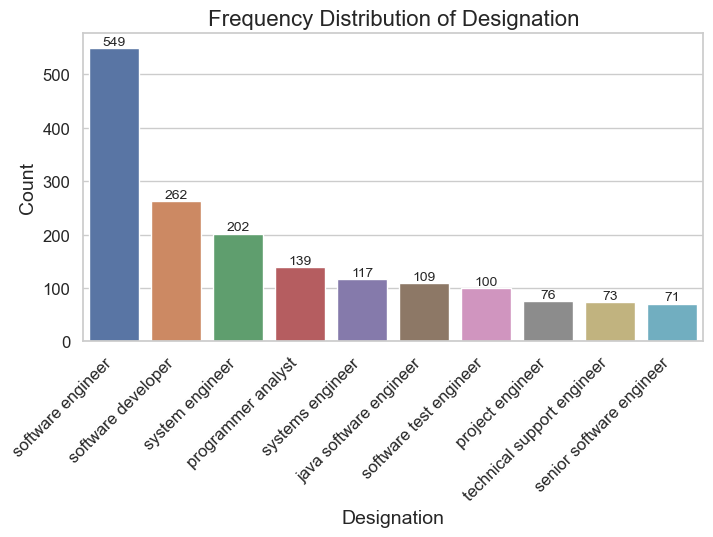

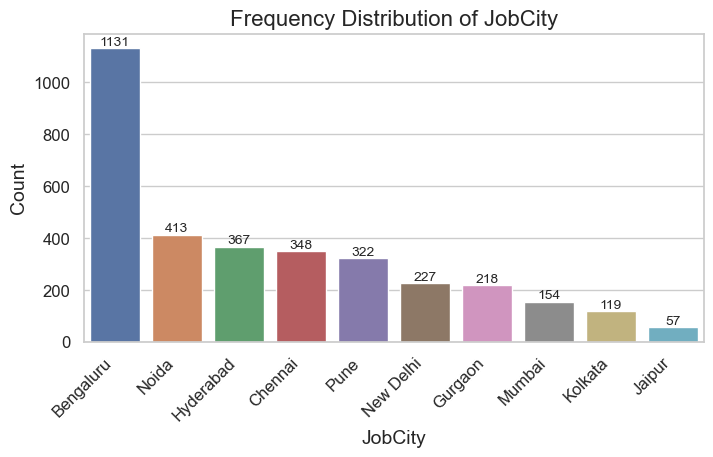

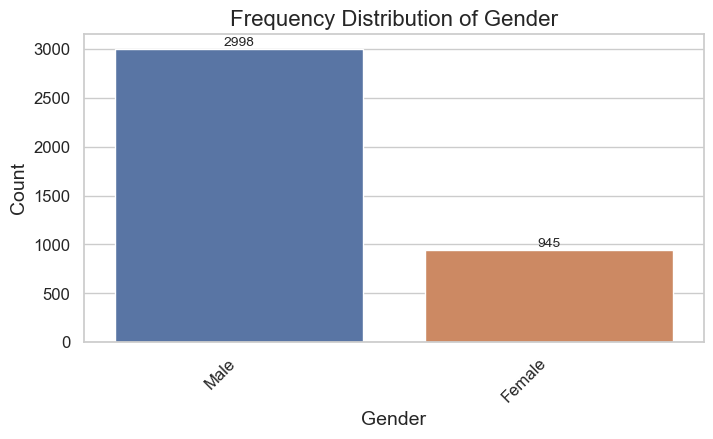

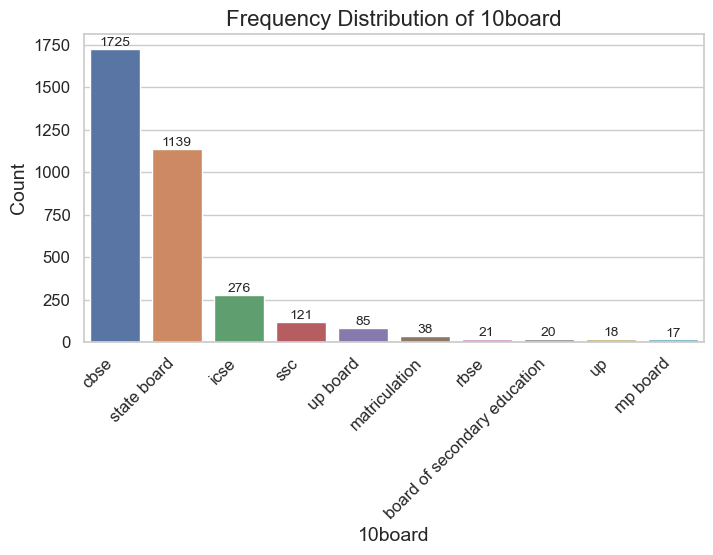

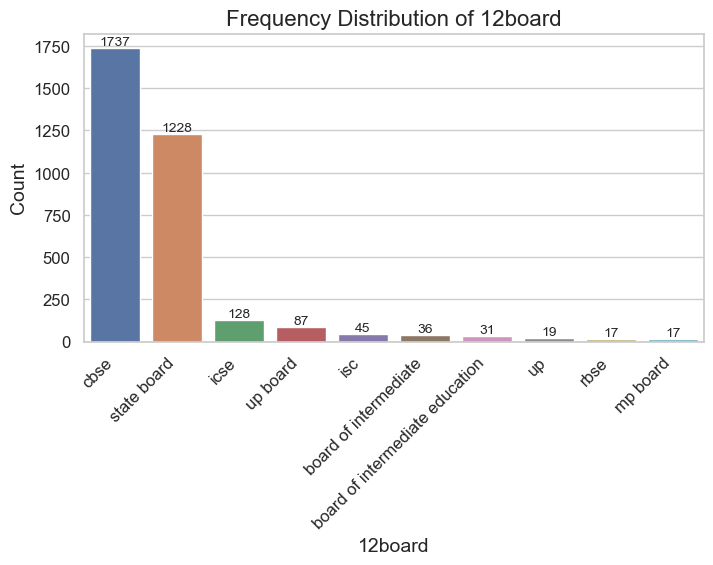

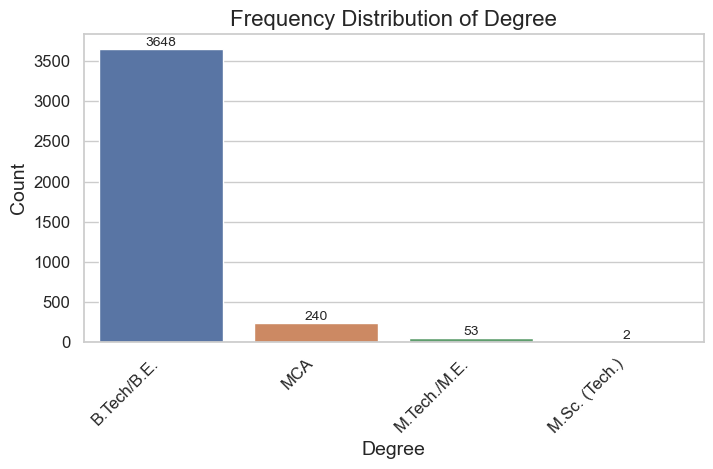

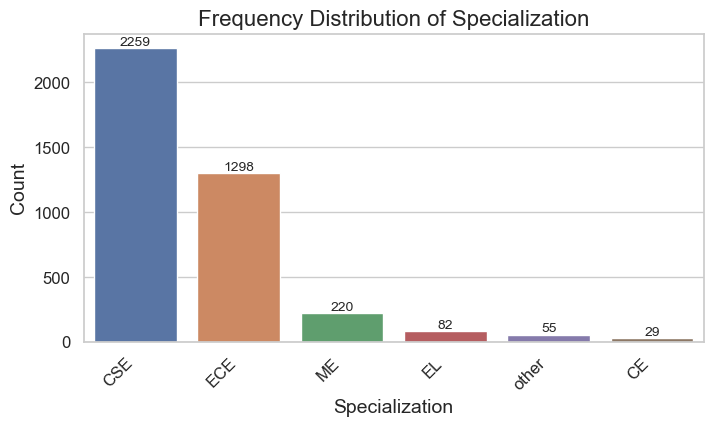

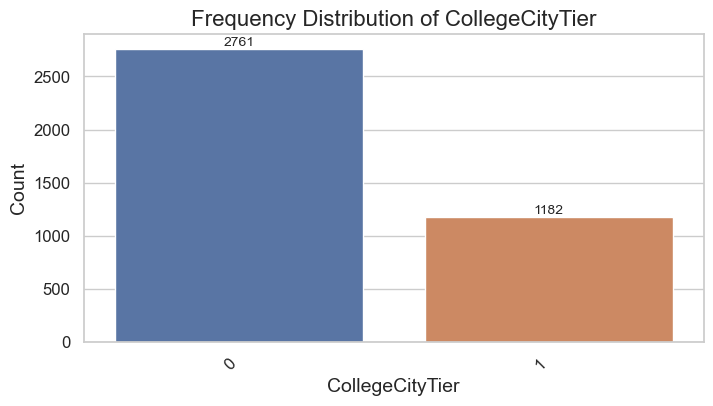

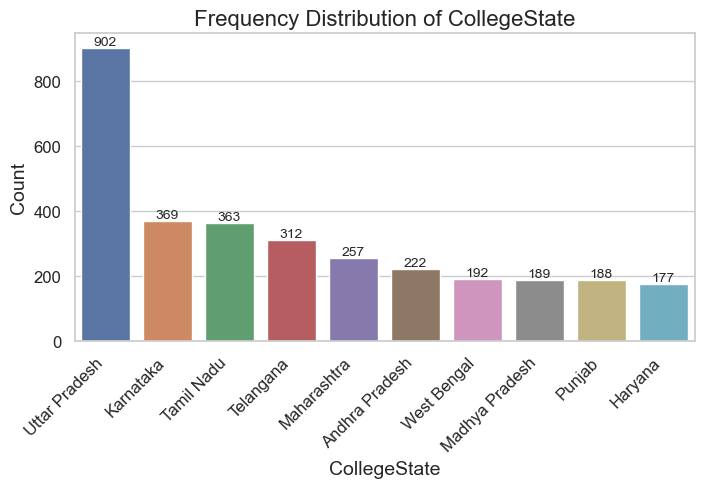

In [49]:
categorical_columns = df.select_dtypes(include=["object"]).columns

for column in categorical_columns:
    value_counts = df[column].value_counts()[:10]

    plt.figure(figsize=(8, 4))
    
    sns.barplot(x=value_counts.index, y=value_counts.values)

    plt.title(f'Frequency Distribution of {column}', fontsize=16)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Adding count values on top of the bars
    for i, v in enumerate(value_counts.values):
        plt.text(i, v + 0.05, round(v, 2), ha='center', va='bottom', fontsize=10)

    plt.show()

# Bivariate Analysis

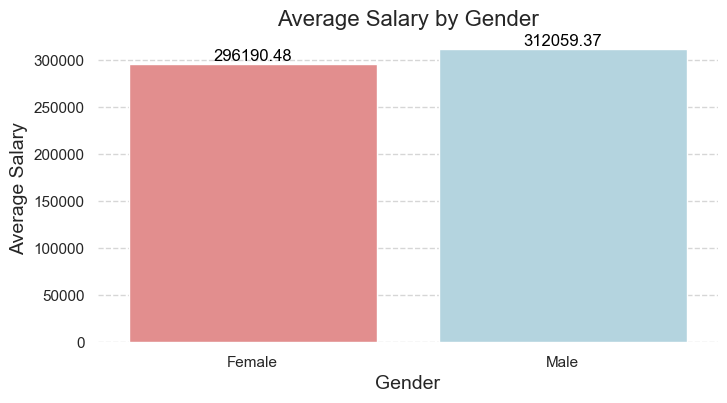

In [50]:
custom_palette = {'Male': 'lightblue', 'Female': 'lightcoral'}

plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Gender', y='Salary', data=df, estimator=lambda x: sum(x) / len(x),
                 palette=custom_palette, ci=None) 

plt.title('Average Salary by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Average Salary', fontsize=14)


for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.2f}',
            ha='center', va='bottom', fontsize=12, color='black')


plt.grid(axis='y', linestyle='--', alpha=0.8)
sns.despine(left=True, bottom=True)

plt.show()

In [51]:
average_salary_by_gender = df.groupby('Gender')['Salary'].mean()
print(average_salary_by_gender)

Gender
Female    296190.476190
Male      312059.372915
Name: Salary, dtype: float64


In [52]:
fig = px.box(df, x='Gender', y='Salary',
             points="all",  # Display all data points
             color='Gender',  # Color by Gender
             labels={'Gender': 'Gender', 'Salary': 'Salary'},  # Label customization
             title='Box Plot of Salary by Gender')

fig.update_traces(marker=dict(size=5, opacity=0.7))  


fig.show()

In [53]:
top_designations_high_salary = list(df.sort_values("Salary", ascending=False)["Designation"].unique())[:15]
subset_df = df[df['Designation'].isin(top_designations_high_salary)]

# Group by Designation and find the maximum salary for each
max_salary_df = subset_df.groupby("Designation")["Salary"].max().reset_index()
max_salary_df = max_salary_df.sort_values("Salary", ascending=False)

fig = px.bar(max_salary_df, x='Designation', y='Salary',
             labels={'Salary': 'Max Salary', 'Designation': 'Designation'},
             color_discrete_sequence=['skyblue'],  
             title='Top 15 Designations, Max Salary')

fig.update_layout(xaxis=dict(tickmode='array',
                             tickvals=list(range(len(max_salary_df))),
                             ticktext=max_salary_df['Designation']),
                  xaxis_title='Designation', yaxis_title='Max Salary',
                  title='Top 15 Designations, Max Salary')

fig.show()

### The top designations based on the highest salary are Automation Engineer, followed by Senior Software Engineer with a maximum value of 4 million, and Assistant System Engineer, along with other professions.

In [54]:
fig = px.box(df, x='Salary', y='Specialization', title='Salary levels by specialization',
             labels={'Salary': 'Salary', 'Specialization': 'Specialization'},color='Specialization')

# Show the plot
fig.show()

### The median salary is nearly similar across all specializations. However, individuals with specializations in CSE and ECE tend to have a higher percentage of higher-paying positions compared to other specializations.

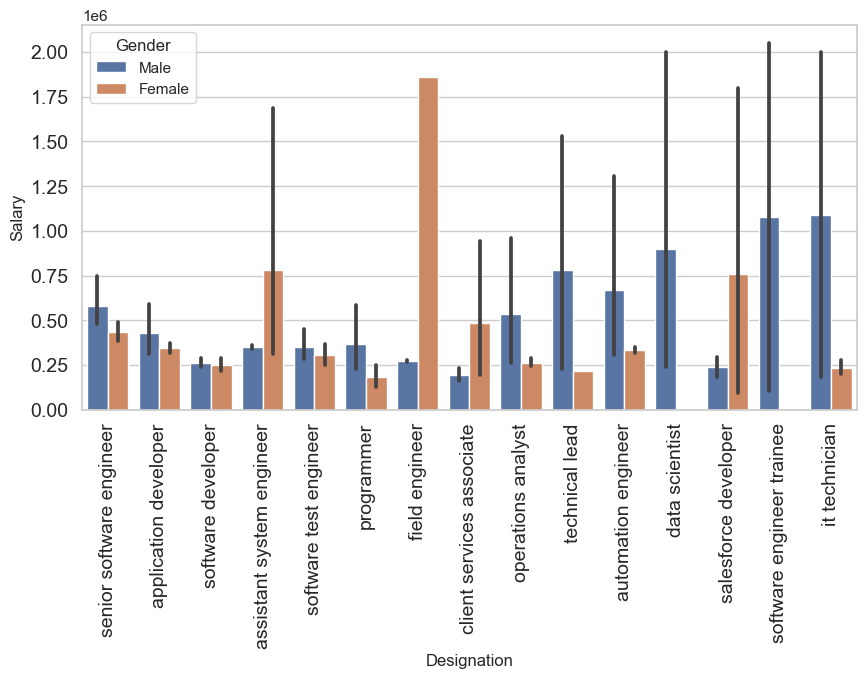

In [55]:
plt.figure(figsize=(10,5))
sns.barplot(x='Designation',y='Salary',hue='Gender',data=subset_df)
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.show()

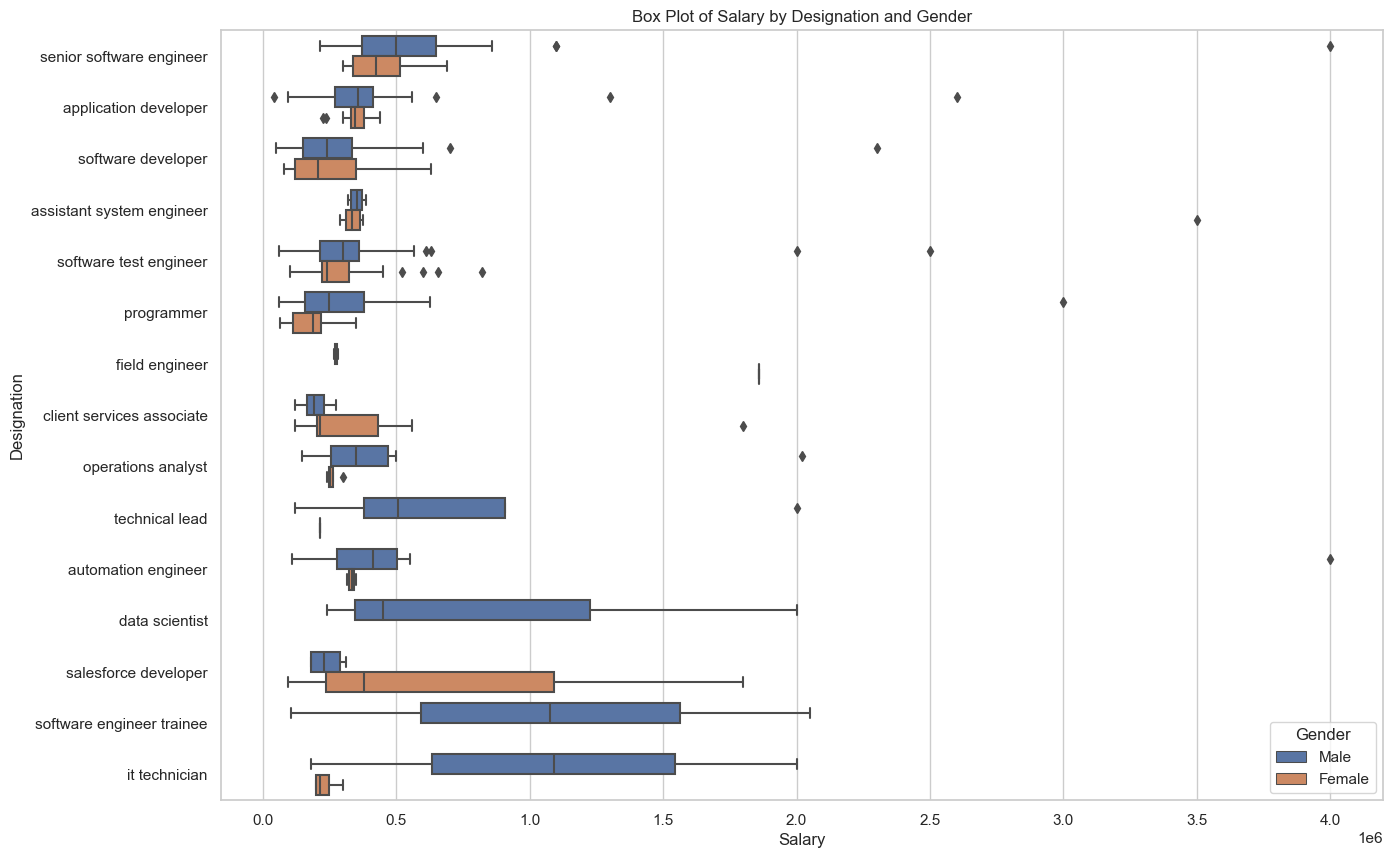

In [56]:
plt.figure(figsize=(15, 10))

# Create a box plot using seaborn
sns.boxplot(data=subset_df, x='Salary', y='Designation', hue='Gender')

# Set labels and title
plt.xlabel('Salary')
plt.ylabel('Designation')
plt.title('Box Plot of Salary by Designation and Gender')

# Show the plot
plt.show()

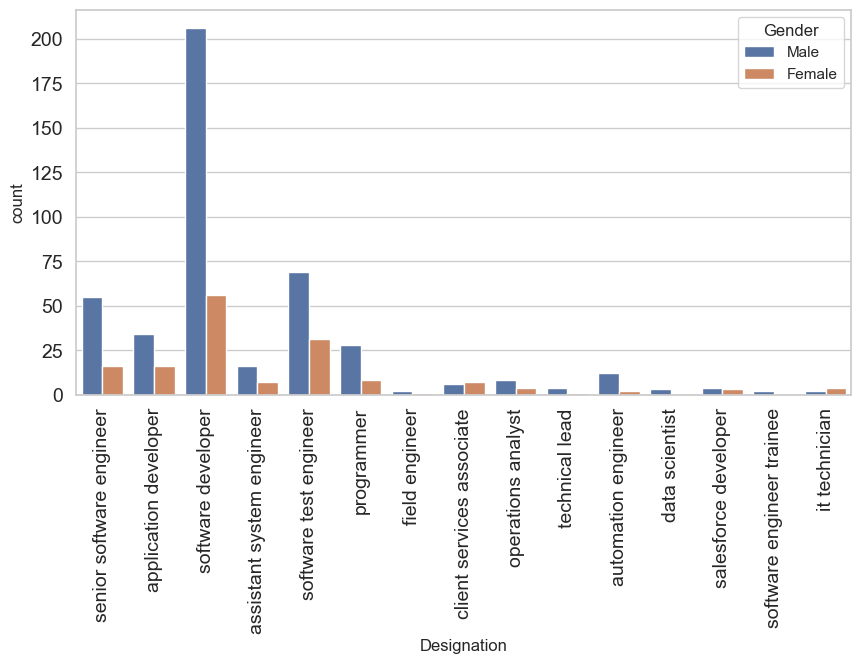

In [57]:
plt.figure(figsize=(10,5))
sns.countplot(x='Designation',hue='Gender',data=subset_df)
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.show()

### The majority of individuals in the top designations, based on the highest salary, hold the title of Software Developer. This field is notably male-dominated, with a substantial difference in gender frequency across various roles.

In [58]:
top_designations = df['Designation'].value_counts()[:15].index.tolist()

top_Designations = df[df['Designation'].isin(top_designations)]
print(f"Unique professions : {len(df['Designation'].unique())}")
top_Designations.head()

Unique professions : 415


Salary        DOJ        DOL               Designation    JobCity  Gender  \
1   500000 2013-09-01 2024-02-23         assistant manager     Indore    Male   
2   325000 2014-06-01 2024-02-23          systems engineer    Chennai  Female   
3  1100000 2011-07-01 2024-02-23  senior software engineer    Gurgaon    Male   
4   200000 2014-03-01 2015-03-01         software engineer    Manesar    Male   
5   300000 2014-06-01 2024-02-23           system engineer  Hyderabad    Male   

         DOB  10percentage      10board  12graduation  ...  Quant    Domain  \
1 1989-10-04         85.40         cbse          2007  ...    780  0.960603   
2 1992-08-03         85.00         cbse          2010  ...    370  0.450877   
3 1989-12-05         85.60         cbse          2007  ...    625  0.974396   
4 1991-02-27         78.00         cbse          2008  ...    465  0.124502   
5 1992-07-02         89.92  state board          2010  ...    620  0.622643   

   ComputerProgramming ElectronicsAndSemicon ComputerScience  \
1                  415                   466               0   
2                  395                     0               0   
3                  615                     0               0   
4                  415                   233               0   
5                  645                     0             407   

   conscientiousness agreeableness extraversion nueroticism  \
1            -0.7335        0.3789       1.2396    -0.10760   
2             0.2718        1.7109       0.1637    -0.86820   
3             0.0464        0.3448      -0.3440    -0.40780   
4            -0.8810       -0.2793      -1.0697     0.09163   
5            -0.3027       -0.6201      -2.2954    -0.74150   

   openess_to_experience  
1                 0.8637  
2                 0.6721  
3                -0.9194  
4                -0.1295  
5                -0.8608  

[5 rows x 31 columns]

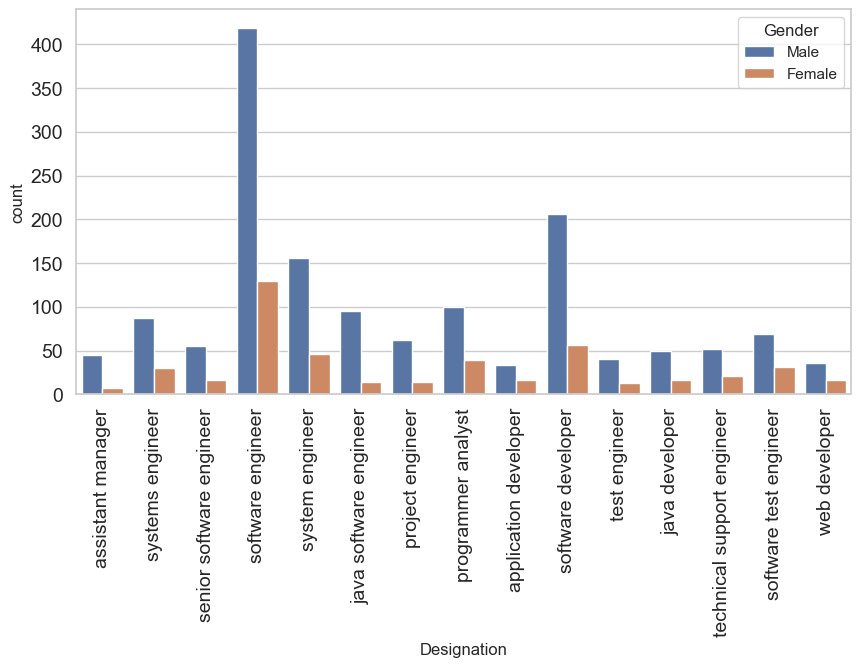

In [59]:
plt.figure(figsize=(10,5))
sns.countplot(x='Designation',hue='Gender',data=top_Designations)
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.show()

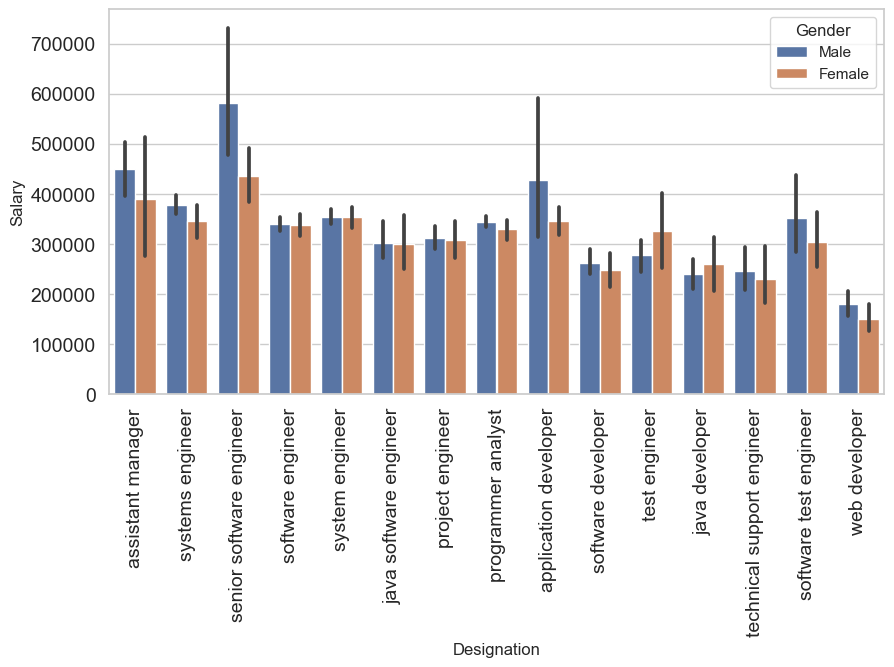

In [60]:
plt.figure(figsize=(10,5))
sns.barplot(x='Designation',y='Salary',hue='Gender',data=top_Designations)
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.show()

### The mean salary for the most frequently held roles appears to be nearly independent of gender. While there are significant differences in some roles, it cannot be conclusively stated that women are being paid less in those positions. These discrepancies may be attributed to factors such as specialization, and other variables.

<Axes: >

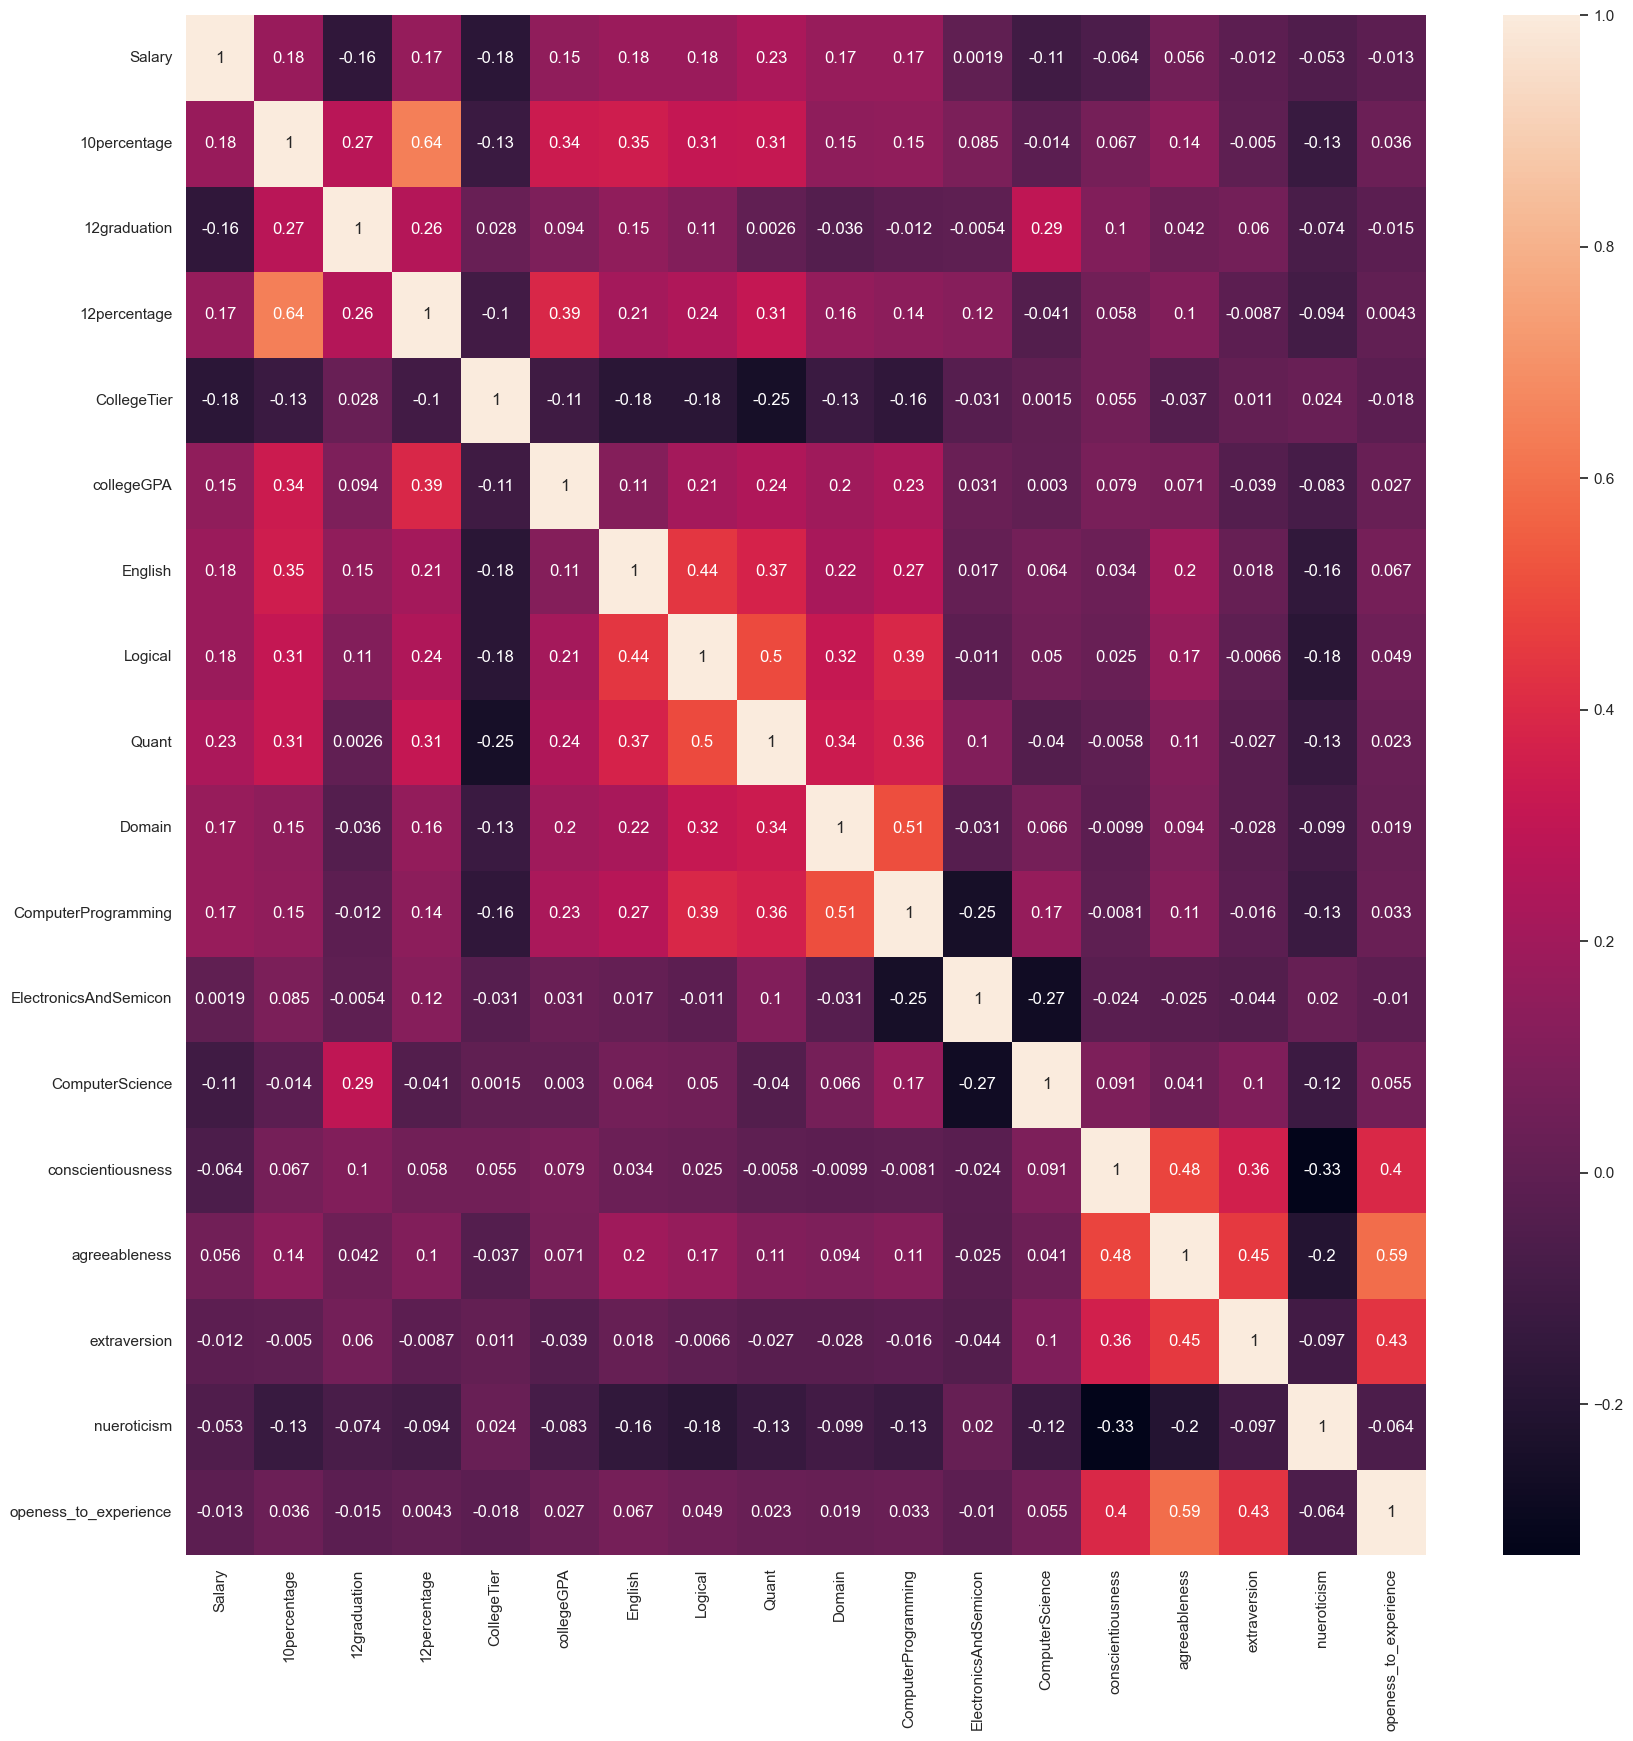

In [61]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)

<Figure size 500x500 with 0 Axes>

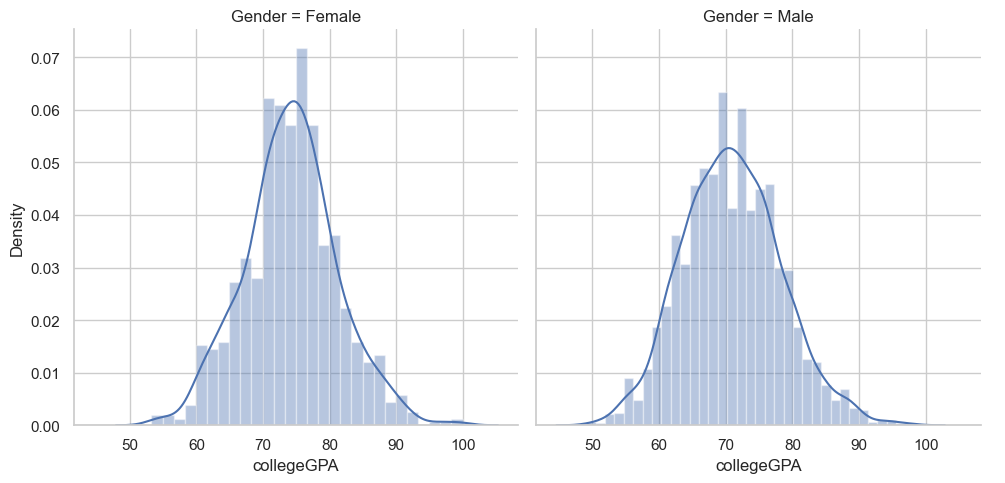

In [62]:
plt.figure(figsize=(5,5))
grid = sns.FacetGrid(data=df, col='Gender', height=5)
grid.map(sns.distplot, 'collegeGPA')
grid.add_legend()
plt.show()

### Both the distributions of college GPA for males and females appear to be normal, centered around the 75% mark. The similarity between the distributions for both genders is evident. The narrow interquartile range (IQR) indicates that a majority of students have similar CGPA in the 70-75% range. However, there are outliers with CGPA below 20 and above 90.

<Figure size 400x400 with 0 Axes>

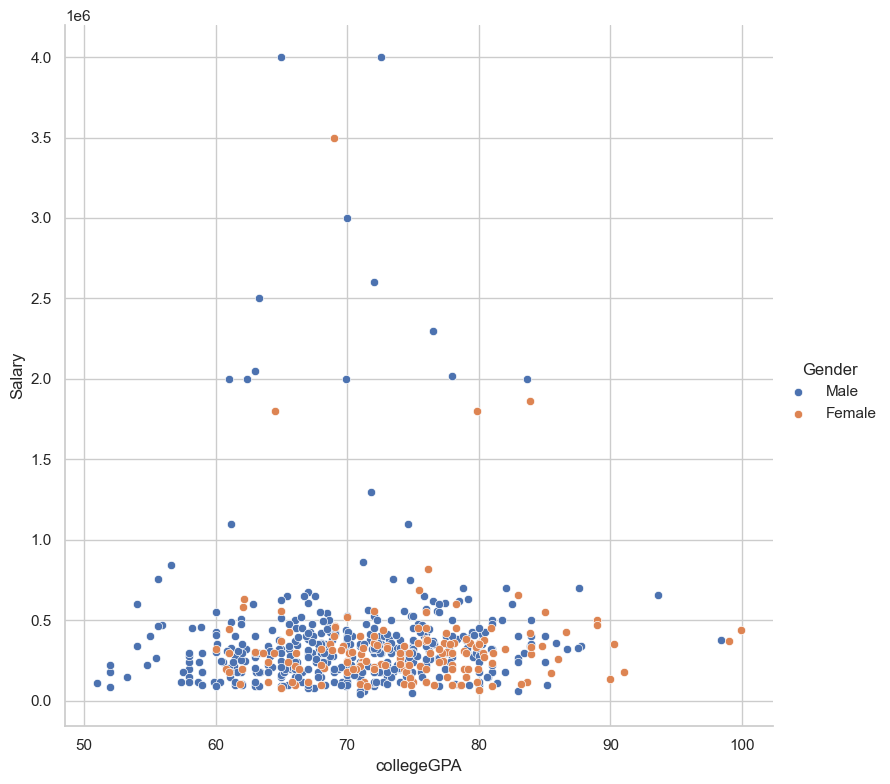

In [63]:
plt.figure(figsize=(4,4))
grid = sns.FacetGrid(data=subset_df,hue='Gender', height=8)
grid.map(sns.scatterplot,'collegeGPA','Salary')
grid.add_legend()
plt.show()

### The majority of both men and women have CGPA in the range of 70-75, which is considered good. There is no observable correlation suggesting that having a high or low GPA significantly impacts salary, and this is consistent for both genders. Therefore, we can infer that GPA is not a decisive factor contributing to the gender pay gap, as the distributions overlap extensively.

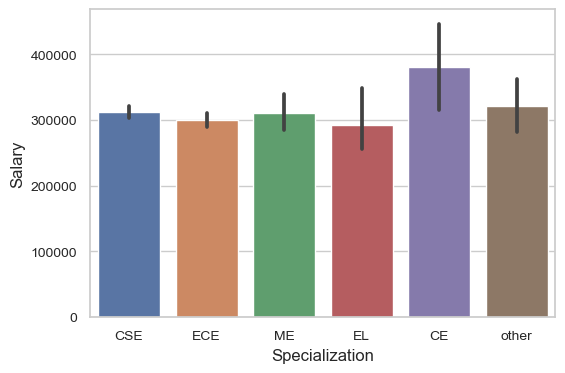

In [64]:
plt.figure(figsize=(6,4))
sns.barplot(data=df,x='Specialization',y='Salary')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Individuals from the CE branch earn the highest average pay, while all other branches receive nearly similar average pay.

<Axes: xlabel='Specialization', ylabel='Salary'>

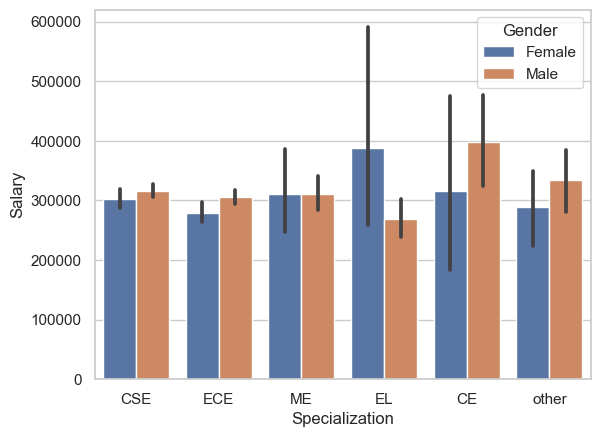

In [65]:
sns.barplot(data=df,x='Specialization',y='Salary',hue='Gender')

- ### Men from CS,EC,CE Earn slightly greater than women from this specialization.
- ### Women from the EL specialization Earns way more than men from same specialization.

<Axes: xlabel='Specialization', ylabel='Salary'>

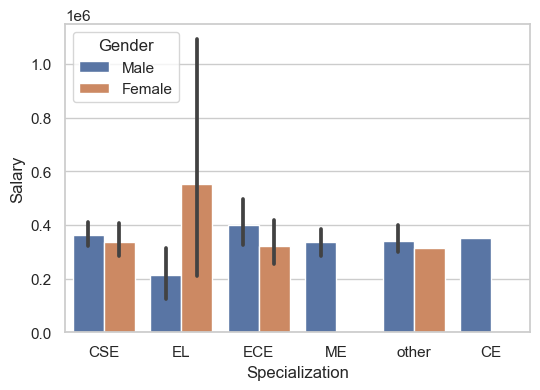

In [66]:
plt.figure(figsize=(6,4))
sns.barplot(data=subset_df,x='Specialization',y='Salary',hue='Gender')

### For those with higher pay, individuals from the CE specialization consist exclusively of men. Specialization does not seem to be the primary reason for the gender pay gap, especially in fields like CS, where men and women earn similar salaries.

In [67]:
subset_df.groupby('CollegeTier').Gender.value_counts()

CollegeTier  Gender
1            Male       32
             Female      8
2            Male      419
             Female    148
Name: Gender, dtype: int64

<Axes: xlabel='CollegeTier', ylabel='Salary'>

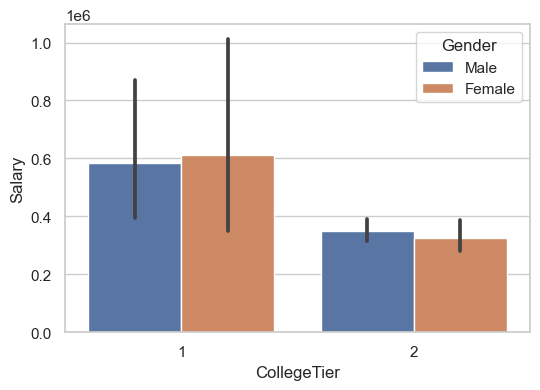

In [68]:
plt.figure(figsize=(6,4))
sns.barplot(data=subset_df,x='CollegeTier',y='Salary',hue='Gender')

### The bar graph indicates that students from tier-1 colleges generally receive higher salaries. It's evident that there are more men from tier-1 colleges than women, and overall, a majority of students come from tier-2 colleges. This could contribute to the gender pay gap, as a significant number of women are from tier-2 colleges.

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140'),
  Text(0, 160.0, '160')])

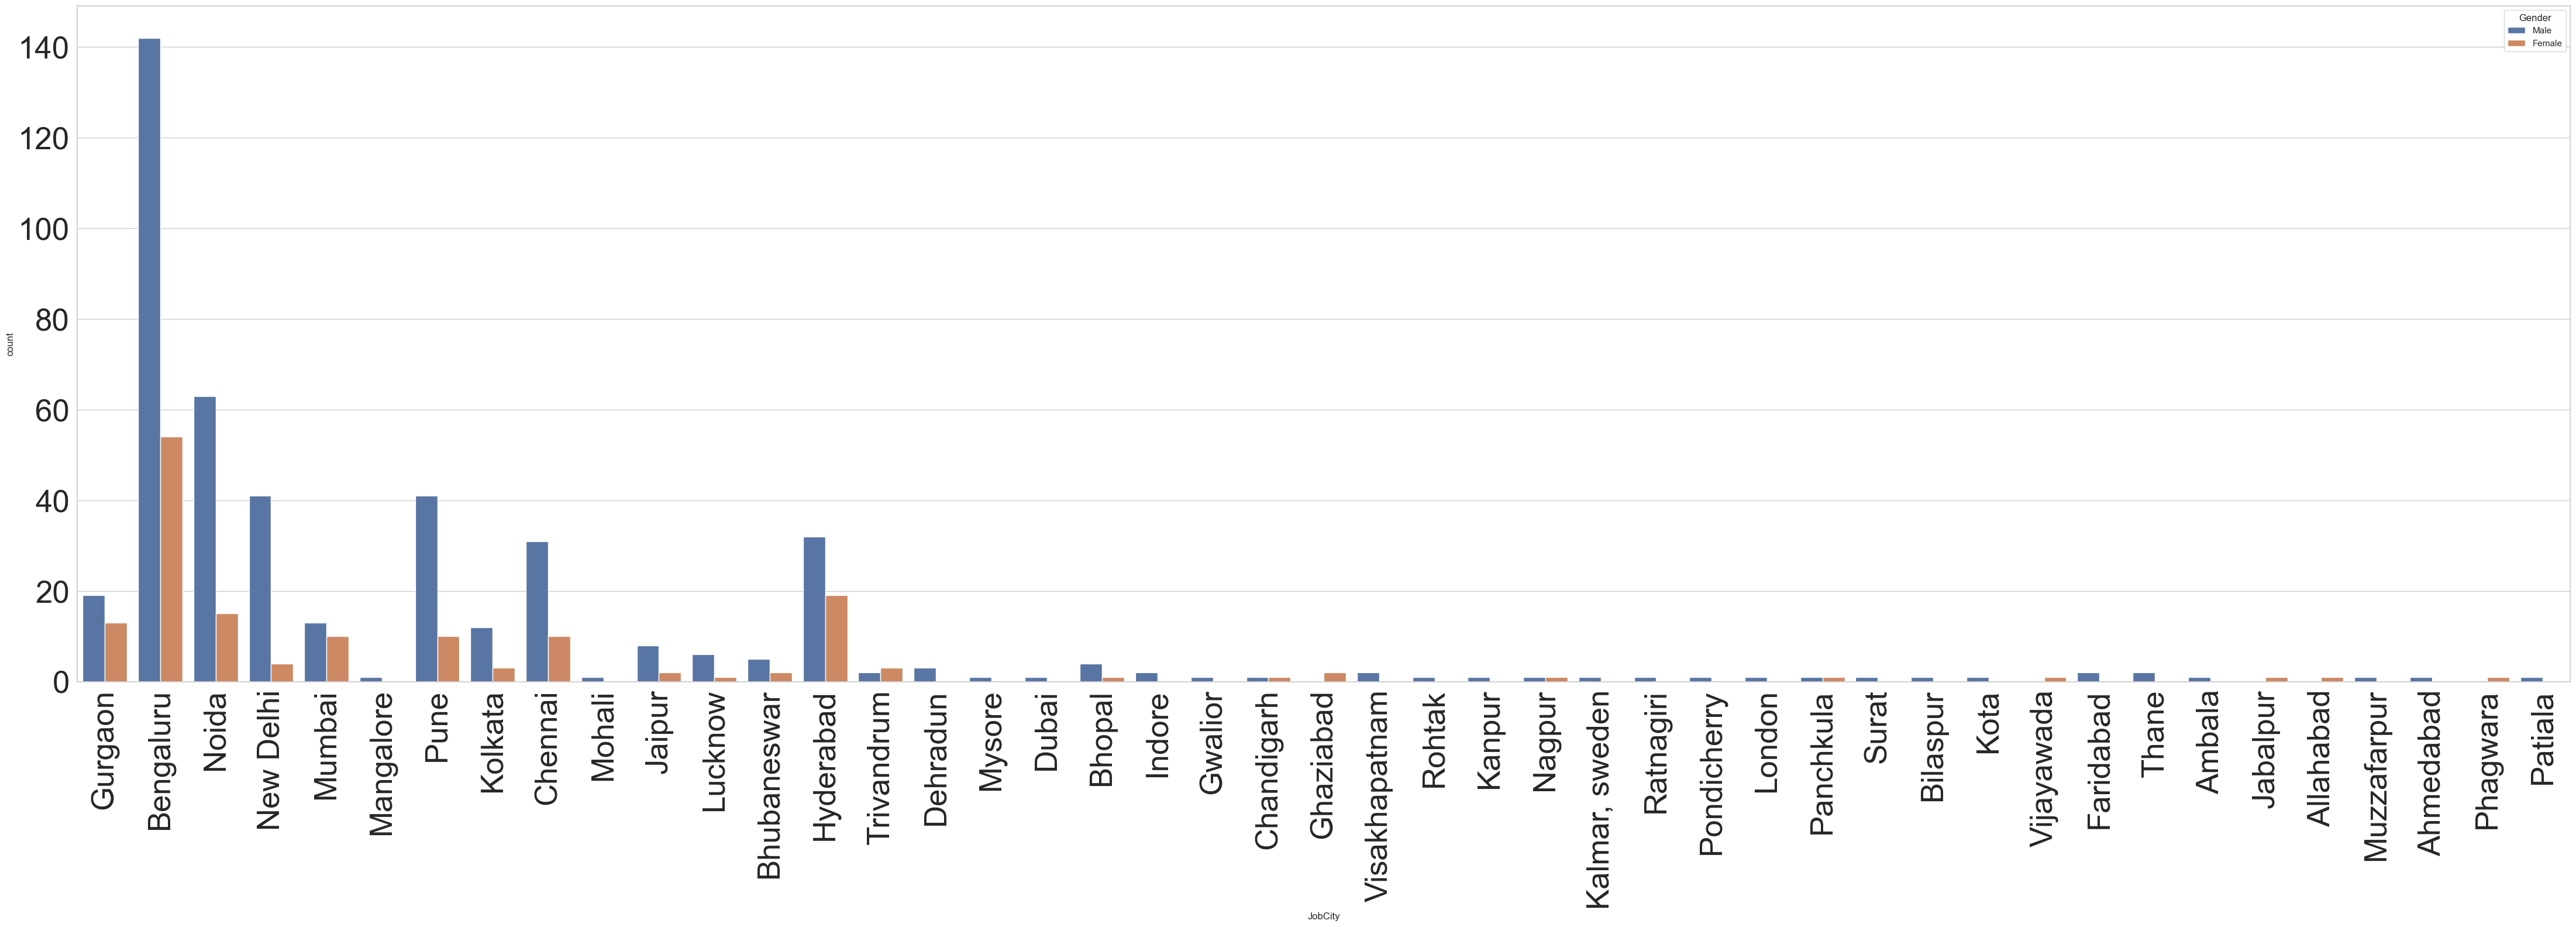

In [69]:
plt.figure(figsize=(55,15))
sns.countplot(x="JobCity",data=subset_df,hue="Gender")
plt.xticks(fontsize=38,rotation=90)
plt.yticks(fontsize=38)

### Most amcat aspirants work in Bengaluru,Noida,Delhi, Hyderabad,Pune and Chennai.

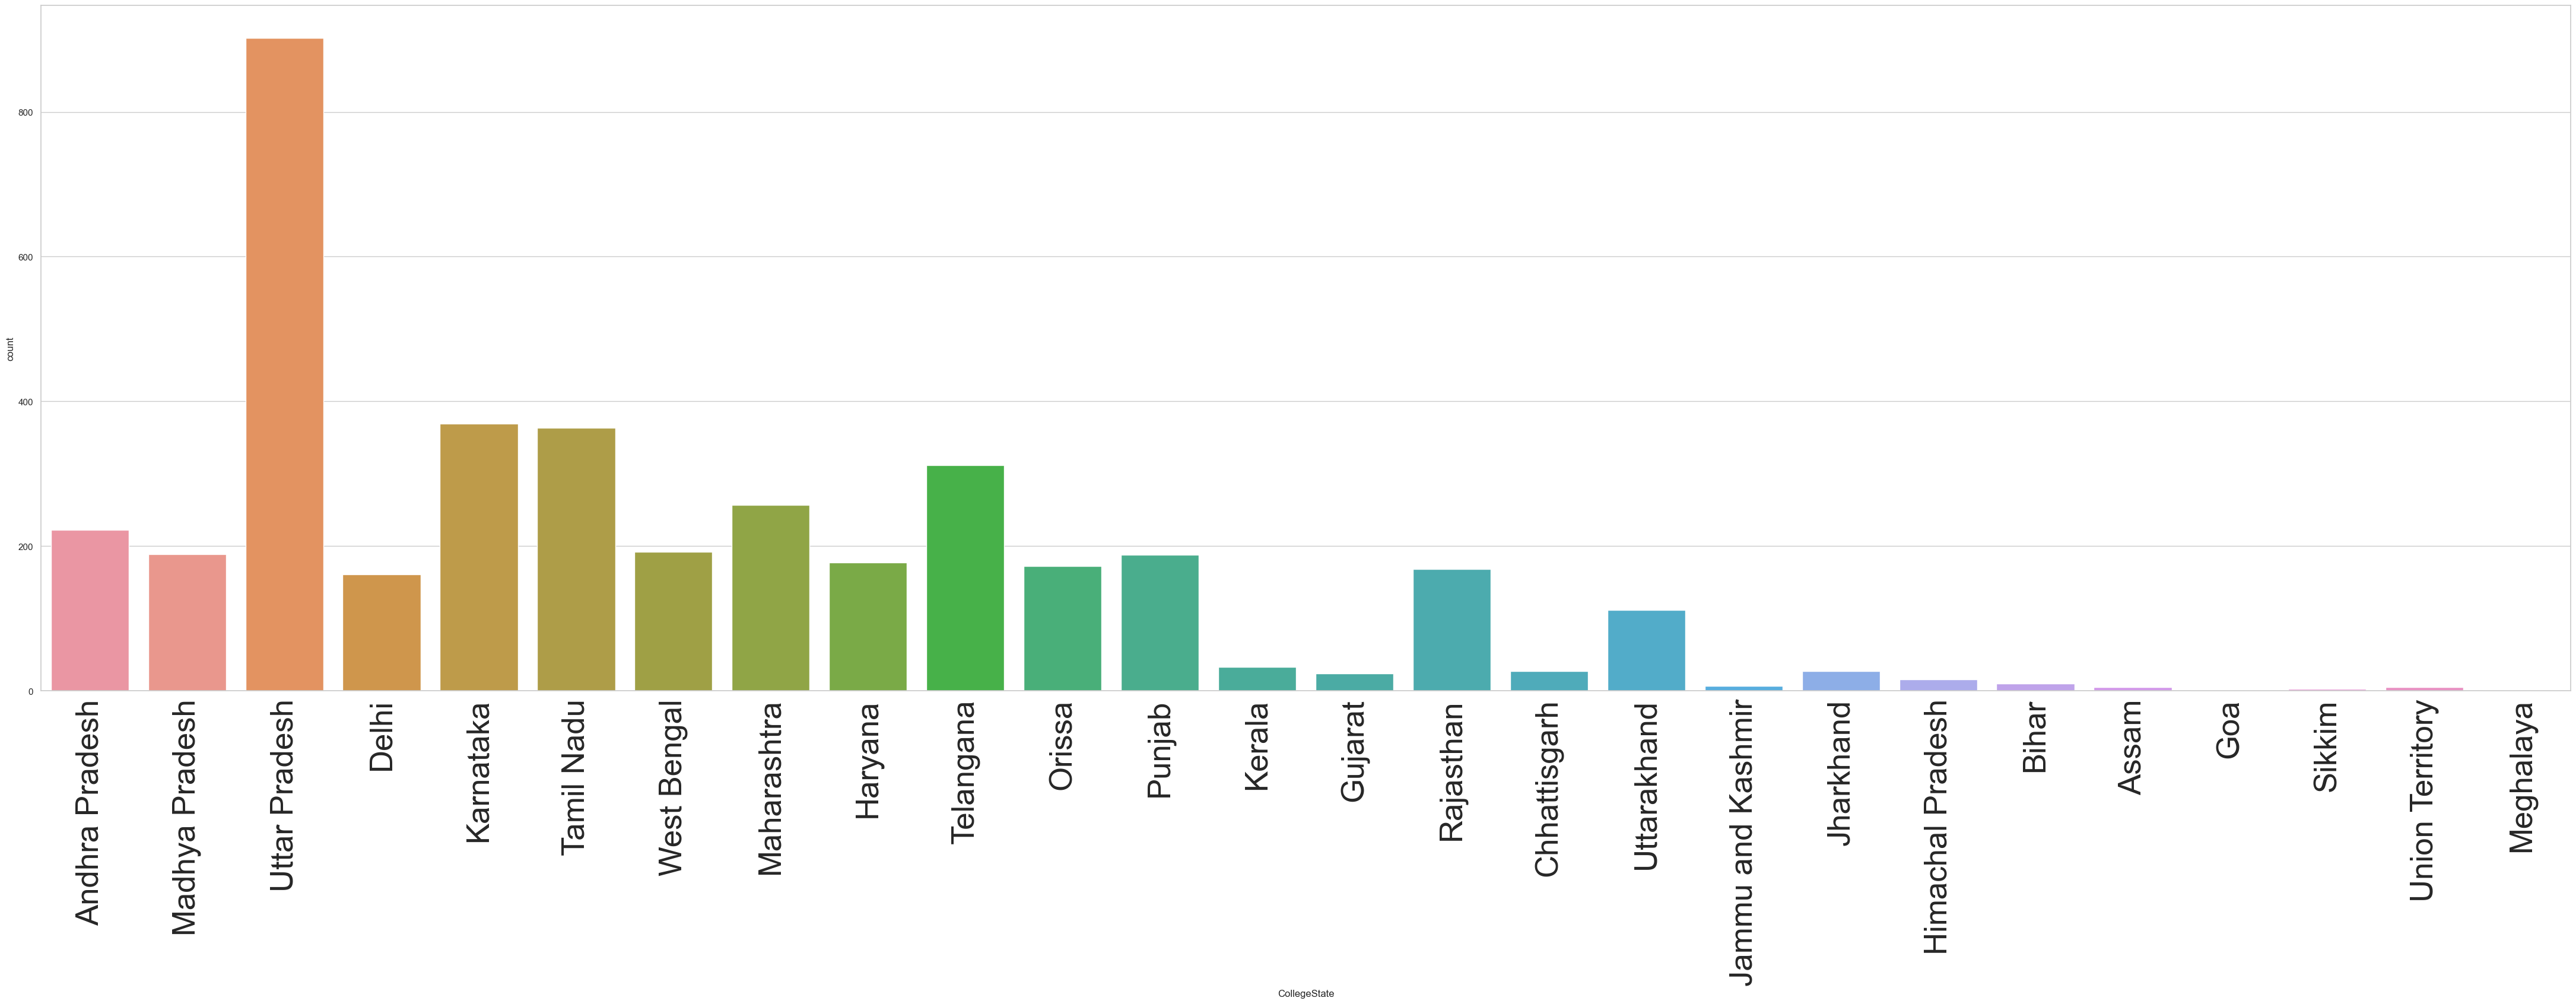

In [70]:
plt.figure(figsize=(55,15))
sns.countplot(data=df,x='CollegeState')
plt.xticks(fontsize=38,rotation=90)
plt.show()

### Most of the Amcat Aspirants are from CSE & ECE specialization.

              10percentage  12percentage  collegeGPA    Salary
10percentage      1.000000      0.642287    0.339866  0.175186
12percentage      0.642287      1.000000    0.387260  0.167854
collegeGPA        0.339866      0.387260    1.000000  0.151128
Salary            0.175186      0.167854    0.151128  1.000000


<Axes: >

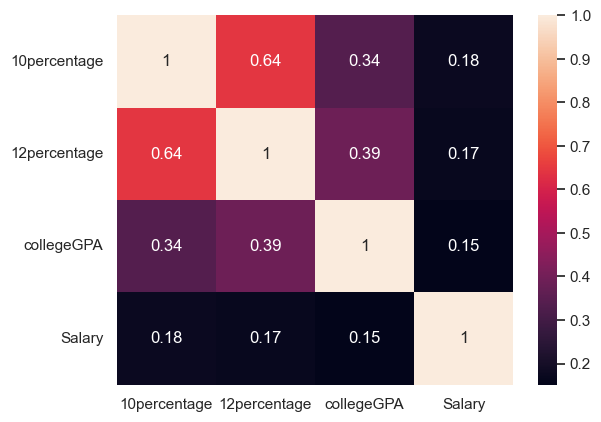

In [71]:
correlation_matrix = df[['10percentage', '12percentage', 'collegeGPA', 'Salary']].corr()
print(correlation_matrix)

sns.heatmap(correlation_matrix,annot=True)

### Salary is not dependent on percentages of 10th,12th and college GPA

# Conclusions

- ### The majority of AMCAT aspirants are male professionals working in the IT domain.They typically hold a degree in BTech, specializing in Computer Science or Information Technology, and mostly graduate from tier-2 colleges in Uttar Pradesh. The average salary for these aspirants is around 300k.

- ### High-paying jobs pursued by AMCAT aspirants are predominantly in the 'IT' domain.

- ### Among the AMCAT aspirants, the most sought-after professions are Software Engineer and Software Developer.

# Research Questions

### For freshers, the starting salary is at least 250k. Additionally, male candidates tend to earn higher salaries than their female colleagues in the initial stages of their careers.

* Null Hypothesis: mu = 250k
* Alternate Hypothesis : mu != 250k

In [72]:
claimed_salary_range = (250000, 300000)

target_roles = ['Programming Analyst', 'Software Engineer', 'Hardware Engineer', 'Associate Engineer']
target_salaries = df[df['Designation'].isin(target_roles)]['Salary']

# Perform one-sample t-test for lower bound
t_stat_lower, p_value_lower = stats.ttest_1samp(target_salaries, popmean=claimed_salary_range[0])

# Perform one-sample t-test for upper bound
t_stat_upper, p_value_upper = stats.ttest_1samp(target_salaries, popmean=claimed_salary_range[1])

# Output results
confidence_level = 0.95
alpha = 1 - confidence_level

if p_value_lower < alpha or p_value_upper < alpha:
    print(f"We reject the claim that the average salary for these roles is within the range of {claimed_salary_range} lakhs.")
else:
    print(f"We fail to reject the claim that the average salary for these roles is within the range of {claimed_salary_range} lakhs.")


We fail to reject the claim that the average salary for these roles is within the range of (250000, 300000) lakhs.


### Is there a relationship between gender and specialization? (i.e. Does the preference of Specialisation depend on the Gender?)
* Null Hypothesis: There is a significant relationship between gender and specialization.
* Alternate Hypothesis : There is no significant relationship between gender and specialization.

In [73]:
plt.figure(figsize=(6, 6))

gender_specialization_table = pd.crosstab(df['Gender'], df['Specialization'])

fig = px.bar(gender_specialization_table, x=gender_specialization_table.index, y=gender_specialization_table.columns,
             title='Stacked Bar Plot of Gender and Specialization', barmode='stack')

fig.show()

<Figure size 600x600 with 0 Axes>

In [74]:
observed_table = pd.crosstab(df['Gender'], df['Specialization'])

# Perform chi-squared test
chi2, p_value, _, _ = chi2_contingency(observed_table)

# Output results
print("Chi-squared statistic:", chi2)
print("p-value:", p_value)
alpha = 0.05
print("\nSignificance level:", alpha)
if p_value < alpha:
    print("There is a significant relationship between gender and specialization.")
else:
    print("There is no significant relationship between gender and specialization.")

Chi-squared statistic: 49.48994880309693
p-value: 1.7621355610003721e-09

Significance level: 0.05
There is a significant relationship between gender and specialization.


## So,The above made claims are True!